# Topic Finder

Project's purpose is to classify titles and abstracts of articles by topic using NLP techniques. Articles are divided for 6 classes, each category is different kind of science. There are:

0: Computer Science

1: Physics

2: Mathematics

3: Statistics

4: Quantitative Biology

5: Quantitative Finance

Source of data: https://www.kaggle.com/c/nlpsci/overview .

<a id="0"></a> <br>
 ## Table of Contents  
1. [Importing and defining functions](#1)     
1. [Data exploration](#2)
1. [Data preprocess](#3)
1. [Splitting datasets](#4)
1. [Modelling using Word2Vec](#5)
    1. [Model trained on training data](#6)
    1. [Using pretrained vectors](#7)
    1. [Bidirectional LSTM model](#8)
    1. [Conv1D model](#9)
1. [Modeling using Tfidf](#10)
    1. [Data without stemming](#11)
    1. [Stemmed data](#12)
1. [More models](#13)
    1. [Word2Vec](#14)
    1. [Tfidf](#15)
1. [Dealing with imbalanced data](#16)
    1. [Word2Vec](#17)
    1. [Tfidf](#18)
1. [Hyperparameter tuning](#19)
    1. [Word2Vec](#20)
        1. [Logistic Regression](#21)
        1. [Support Vector Machines](#22)
        1. [XGBoost Classifier](#23)
        1. [LGBM Classifier](#24)
    1. [Tfidf vectrorizer](#25)
        1. [Logistic Regression](#26)
        1. [Support Vector Machines](#27)
        1. [XGBoost Classifier](#28)
        1. [LGBM Classifier](#29)
1. [Classification using Voting Classifier](#30)
    1. [Word2Vec](#31)
        1. [Hard voting](#32)
        1. [Soft voting](#33)
    1. [Tfidf vectorizer](#34)
        1. [Hard voting](#35)
        1. [Soft voting](#36)
2. [Further analysis of best model](#37)
2. [Conclusion](#38)

<a id="1"></a> 
## 1. Importing and defining functions

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline, make_pipeline
import re
import string
from imblearn.combine import SMOTEENN, SMOTETomek
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
import gensim
import gensim.downloader as api
import warnings 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from catboost import CatBoostClassifier
import time
import random

In [7]:
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [8]:
warnings.filterwarnings('ignore') #ignoring wartning to make view more clear

In [9]:
def top_50_counter(articles):
    
    """
    Generates a DataFrame containing the top 50 most frequently occurring words across a list of text articles.

    Parameters:
    articles (list of str): A list of textual articles to analyze.

    Returns:
    pd.DataFrame: A DataFrame with the top 50 words and their respective occurrence counts, sorted in descending order.
    
    Notes:
    - Uses CountVectorizer from sklearn with English stop words removed.
    - Ignores words that appear in fewer than 5 documents.
    """
    
    model = CountVectorizer(stop_words='english', min_df=5)
    
    cv = model.fit_transform(articles)
    
    cv_df = pd.DataFrame(cv.toarray(), columns=model.get_feature_names_out())
    
    df_sorted = pd.DataFrame(cv_df.sum().sort_values(ascending=False)[0:50], columns=['number_of_words'])
    
    return df_sorted

In [10]:
def top_50_barplot(dataframe, column, title):
    
    """
    Plots a horizontal bar chart for the top 50 most frequently occurring words.

    Parameters:
    dataframe (pd.DataFrame): A DataFrame containing word counts.
    column (str): The column name in the DataFrame representing word frequencies.
    title (str): The title for the bar plot.

    Returns:
    None: Displays a horizontal bar plot.

    Notes:
    - The function expects the DataFrame index to contain word labels.
    - Uses Seaborn and Matplotlib for visualization.
    - Adjusts figure size for better readability.
    """
    
    plt.figure(figsize=(12,12))
    
    plt.title(title)
    
    sns.barplot(x=column, y=dataframe.index, data=dataframe)
    
    plt.show()

In [11]:
def components_importance_plot(articles, title):
    
    """
    Generates a horizontal bar plot of the top 50 most important words 
    from the first principal component of an SVD transformation on TF-IDF features.

    Parameters:
    articles (list of str): A list of text documents for analysis.
    title (str): The title for the bar plot.

    Returns:
    None: Displays a bar plot of the top 50 most influential words.

    Notes:
    - Uses Truncated SVD to reduce dimensionality to 2 components.
    - Applies TF-IDF vectorization with English stop words removed.
    - Extracts the most influential words from the first SVD component.
    - Uses Seaborn and Matplotlib for visualization.
    - Requires NumPy, Pandas, Scikit-learn, Seaborn, and Matplotlib.
    """
        
    svd = TruncatedSVD(n_components=2, random_state=123)
    
    tfidf = TfidfVectorizer(stop_words='english')
    
    text_vect = tfidf.fit_transform(articles)
    
    text_comp = svd.fit_transform(text_vect)
    
    components = svd.components_
    
    feature_names = tfidf.get_feature_names_out()
    
    top_component_indices = components[0].argsort()[::-1][:50]
    
    top_feature_names = [feature_names[i] for i in top_component_indices]
    
    comp_dict = {}
    
    for key in top_feature_names:
        indx = np.where(feature_names == key)[0][0]
        value = components[0, indx]
        comp_dict[key] = value
        
    comp_df = pd.DataFrame(pd.Series(comp_dict), columns=['values'])
    
    plt.figure(figsize=(12, 12))
    plt.title(title)
    sns.barplot(y=comp_df.index, x='values', data=comp_df)
    plt.show()

<a id="2"></a> 
## 2. Data exploration

First step after importing modules and defining necessary functions is to open our dataset. Dataset is saved in the file called 'train.csv'. Another thing what we need to do is checking what kind of data we have in each column. 

In [14]:
df = pd.read_csv('train.csv', index_col='ID')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15972 entries, 1 to 15972
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   TITLE     15972 non-null  object
 1   ABSTRACT  15972 non-null  object
 2   label     15972 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 499.1+ KB


As we can see columns 'TITLE' and 'ABSTRACT' are object type columns, what means that probably they contain text. We will check it later. Column 'label' is int64 type column - this will be our target. Let's dive into that column by checking how many records contains eeach class:

In [17]:
df['label'].value_counts()

label
0    6539
1    4203
2    3349
3    1381
4     339
5     161
Name: count, dtype: int64

By checking numbers of record by each class we can see that dataset is very imbalanced. First three categories have much more representation in data than rest of them. Look at the proportions:

In [19]:
df['label'].value_counts(normalize=True)

label
0    0.409404
1    0.263148
2    0.209679
3    0.086464
4    0.021225
5    0.010080
Name: proportion, dtype: float64

As we can see first three categories contain almost 70 % of available data. Look at numbers of records what we have:

In [21]:
df.shape

(15972, 3)

Dataset contain 15972 rows.
Now look for the first 5 rows of data, to check how dataset is looking like:

In [23]:
df.head()

,TITLE,ABSTRACT,label
ID,,,
1,Detecting the impact of public transit on the ...,"In many developing countries, public transit...",0
2,Is Proxima Centauri b habitable? -- A study of...,We address the important question of whether...,1
3,Verifying Security Protocols using Dynamic Str...,Current formal approaches have been successf...,0
4,Scenic: Language-Based Scene Generation,Synthetic data has proved increasingly usefu...,0
5,Near-Optimal Discrete Optimization for Experim...,The experimental design problem concerns the...,0


As I said before, first two columns contain text data. We can conclude that they are how they are named. For further analysis we can check what is the mean of the number of words in the each of those columns:

In [25]:
title_lens = []
for title in df['TITLE']:
    title_lens.append(len(title.split()))

In [26]:
np.mean(title_lens)

9.506135737540696

Average number of wortd in 'TITLE' column is 9.5.

In [28]:
abstract_lens = []
for abstract in df['ABSTRACT']:
    abstract_lens.append(len(abstract.split()))

In [29]:
np.mean(abstract_lens)

148.75582268970697

And in 'ABSTRACT' column we have 148.76 words in average.

For further analysis we will combine those two columns to have one text column.

In [31]:
df['text'] = df['TITLE'] + ' ' + df['ABSTRACT']

Take a look for the results:

In [33]:
df.iloc[0]['text']

'Detecting the impact of public transit on the transmission of epidemics   In many developing countries, public transit plays an important role in daily\nlife. However, few existing methods have considered the influence of public\ntransit in their models. In this work, we present a dual-perspective view of\nthe epidemic spreading process of the individual that involves both\ncontamination in places (such as work places and homes) and public transit\n(such as buses and trains). In more detail, we consider a group of individuals\nwho travel to some places using public transit, and introduce public transit\ninto the epidemic spreading process. A novel modeling framework is proposed\nconsidering place-based infections and the public-transit-based infections. In\nthe urban scenario, we investigate the public transit trip contribution rate\n(PTTCR) in the epidemic spreading process of the individual, and assess the\nimpact of the public transit trip contribution rate by evaluating the volume

As we can see data contains symbols like '\n' and '\t' whicch means free spaces. For our analysis we don't need them. Let's make operation to delate those symbols by using regex:

In [35]:
empty_list = []
for art in df['text']:
    art = re.sub("\n|\t", " ", art) # using simple regex to delete spaces
    empty_list.append(art)
df['text'] = empty_list

In [36]:
df.iloc[0]['text']

'Detecting the impact of public transit on the transmission of epidemics   In many developing countries, public transit plays an important role in daily life. However, few existing methods have considered the influence of public transit in their models. In this work, we present a dual-perspective view of the epidemic spreading process of the individual that involves both contamination in places (such as work places and homes) and public transit (such as buses and trains). In more detail, we consider a group of individuals who travel to some places using public transit, and introduce public transit into the epidemic spreading process. A novel modeling framework is proposed considering place-based infections and the public-transit-based infections. In the urban scenario, we investigate the public transit trip contribution rate (PTTCR) in the epidemic spreading process of the individual, and assess the impact of the public transit trip contribution rate by evaluating the volume of infecti

Now our data can be processed. Right now we also don't need primary text columns, we can delete them.

In [38]:
df = df.drop(['TITLE', 'ABSTRACT'], axis=1)

First idea which I have, how to analize the dataset, whoch contain text is o check most frequent words in dataset. For that purpose w will use one of the functions defined in the beginning in the notebook. Take a look for most 50 frequent words:

In [40]:
top_50 = top_50_counter(df['text'])

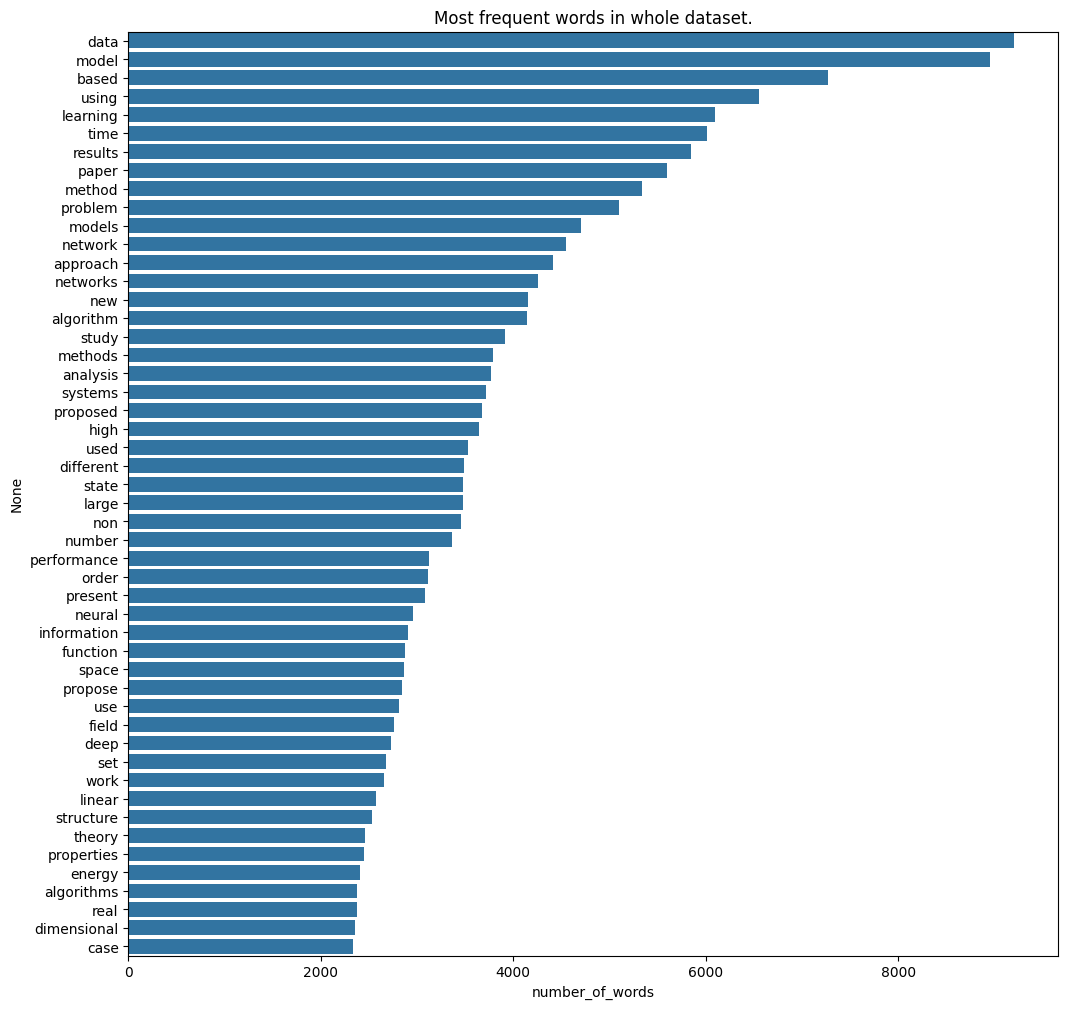

In [41]:
top_50_barplot(top_50, 'number_of_words', 'Most frequent words in whole dataset.')

Our plot do not contain stop words - most frequent words in English. As we can see most words are: data, model, based - words frequently used in science articles.
    
Another method to analize 'importance' of words in dataset is to make variance ranking of words, by using combination of SVD and TFiDF algorithms:

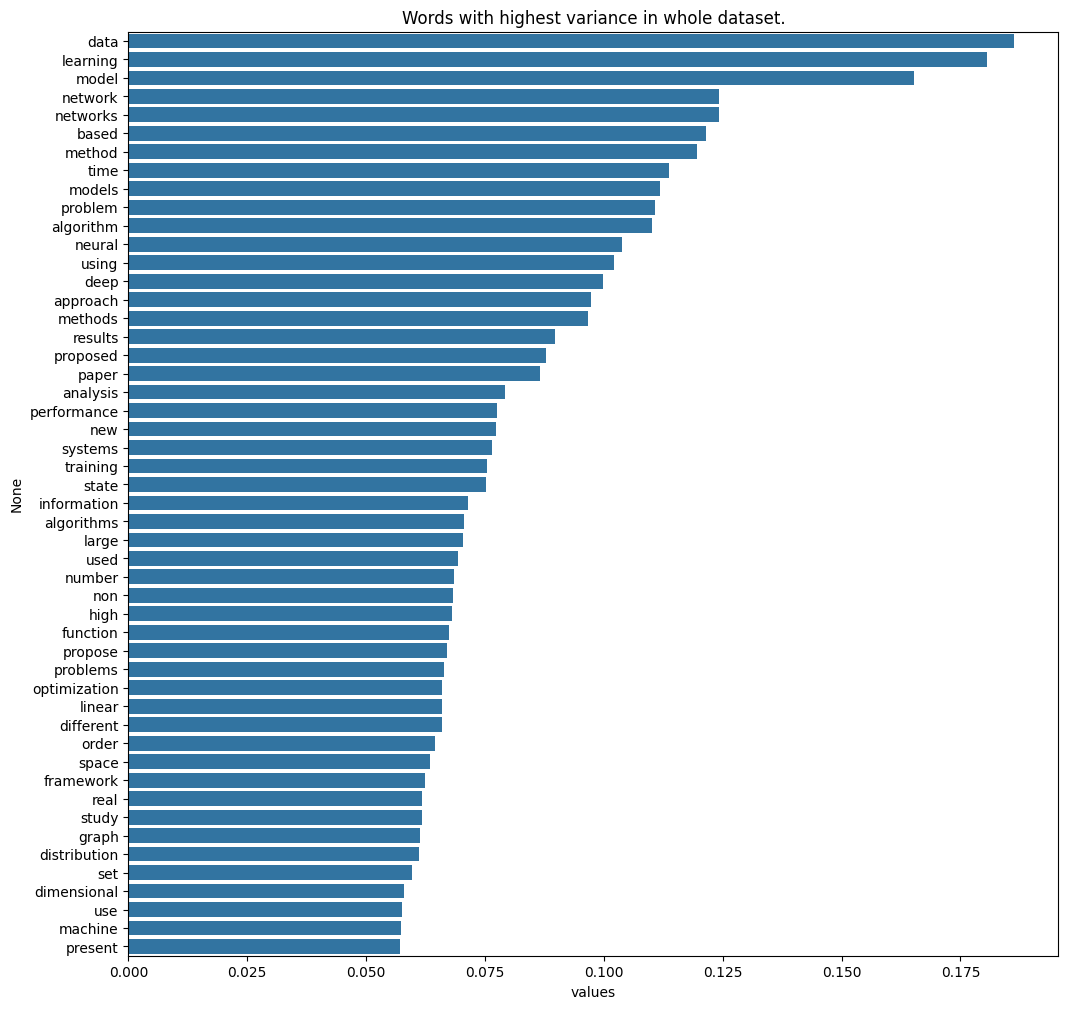

In [43]:
components_importance_plot(df['text'], 'Words with highest variance in whole dataset.')

As we can see some of most frequent words have also highest variance. But we have some differences on each charts. That means, that not number of how many times each word appears in dataset is important in each article.

For further analysis we will check rankings of numbers of words and variance for each category:

In [45]:
comp_sc = df[df['label'] == 0] # Computer Science
physics = df[df['label'] == 1] # Physics
maths = df[df['label'] == 2] # Mathematics
stats = df[df['label'] == 3] # Statistics
biology = df[df['label'] == 4] # Biology
finance = df[df['label'] == 5] # Finance

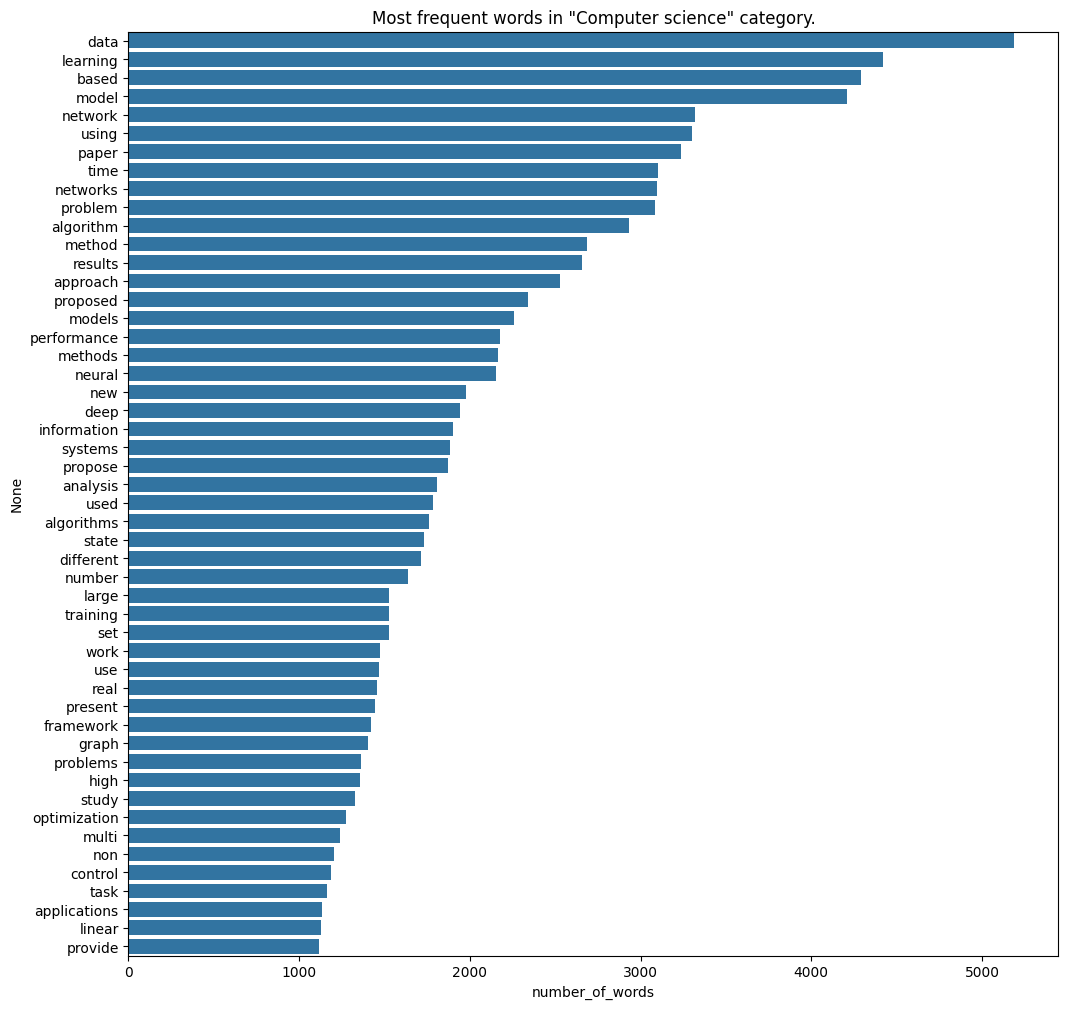

In [46]:
top_50_cs = top_50_counter(comp_sc['text'])
top_50_barplot(top_50_cs, 'number_of_words', 'Most frequent words in "Computer science" category.')

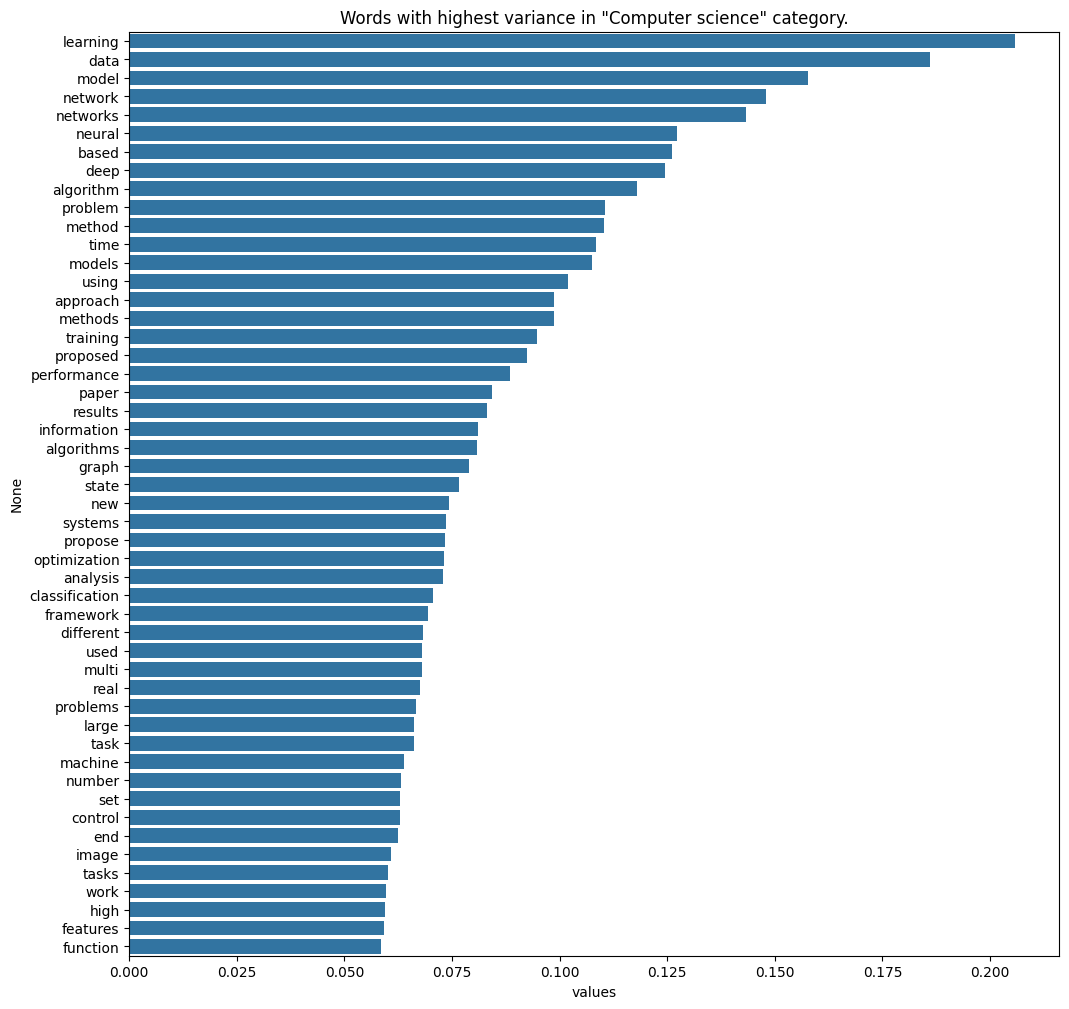

In [47]:
components_importance_plot(comp_sc['text'], 'Words with highest variance in "Computer science" category.')

OK, because 'Computer Science' is the largest category in dataset, some of words are the same as in the general ranking - that's quite logical. 
Lets look for other categories:

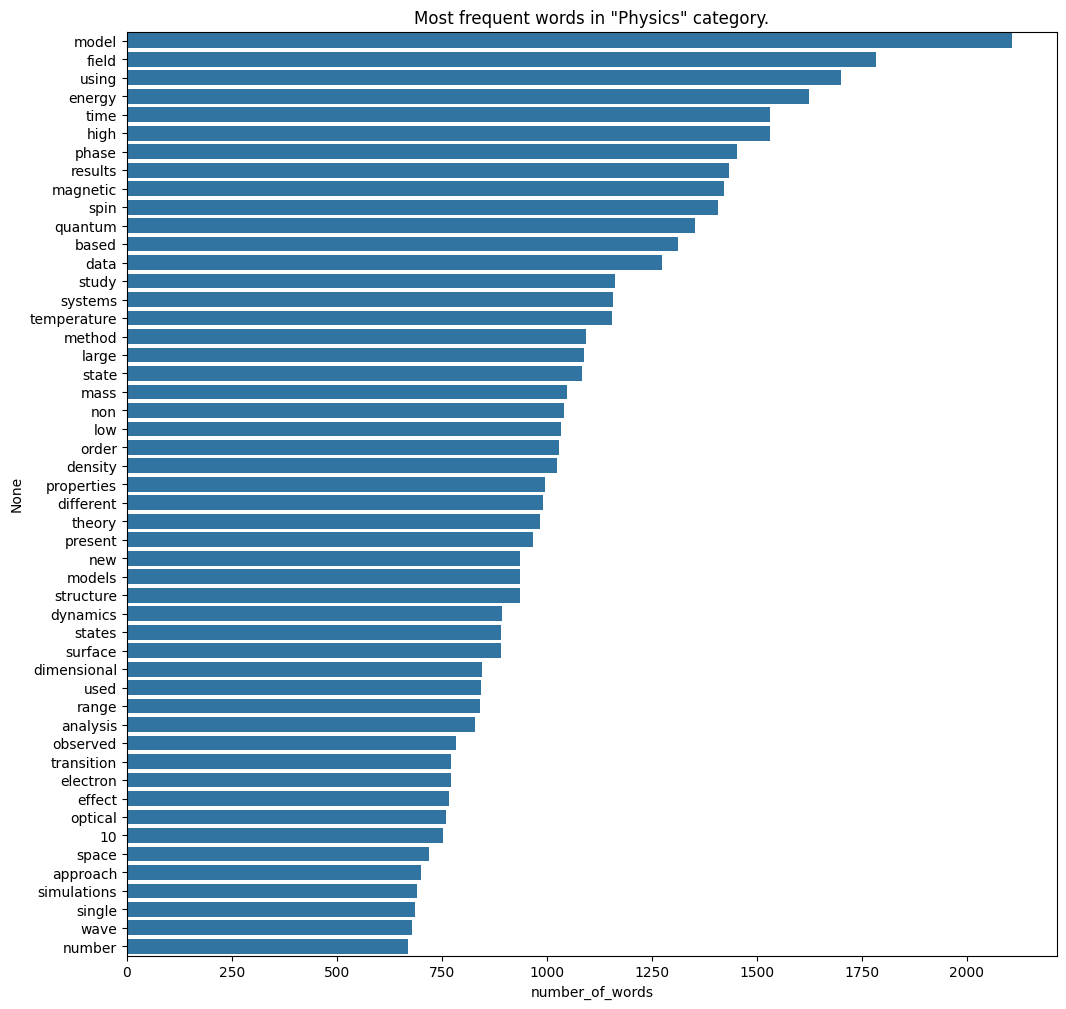

In [49]:
top_50_ph = top_50_counter(physics['text'])
top_50_barplot(top_50_ph, 'number_of_words', 'Most frequent words in "Physics" category.')

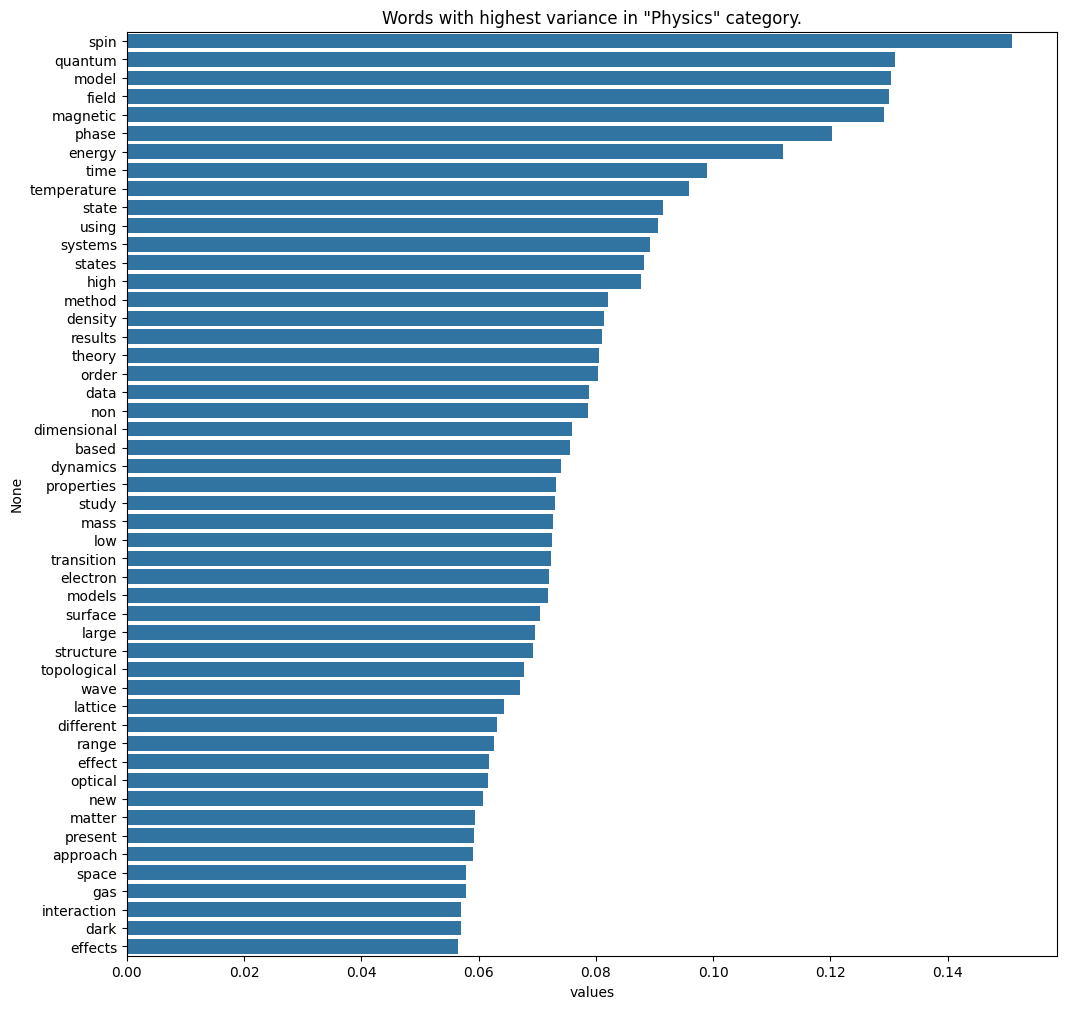

In [50]:
components_importance_plot(physics['text'], 'Words with highest variance in "Physics" category.')

Now we can see that some of words characteristic for Physics start to appear: 'magnetic', 'mass', 'temperature'.

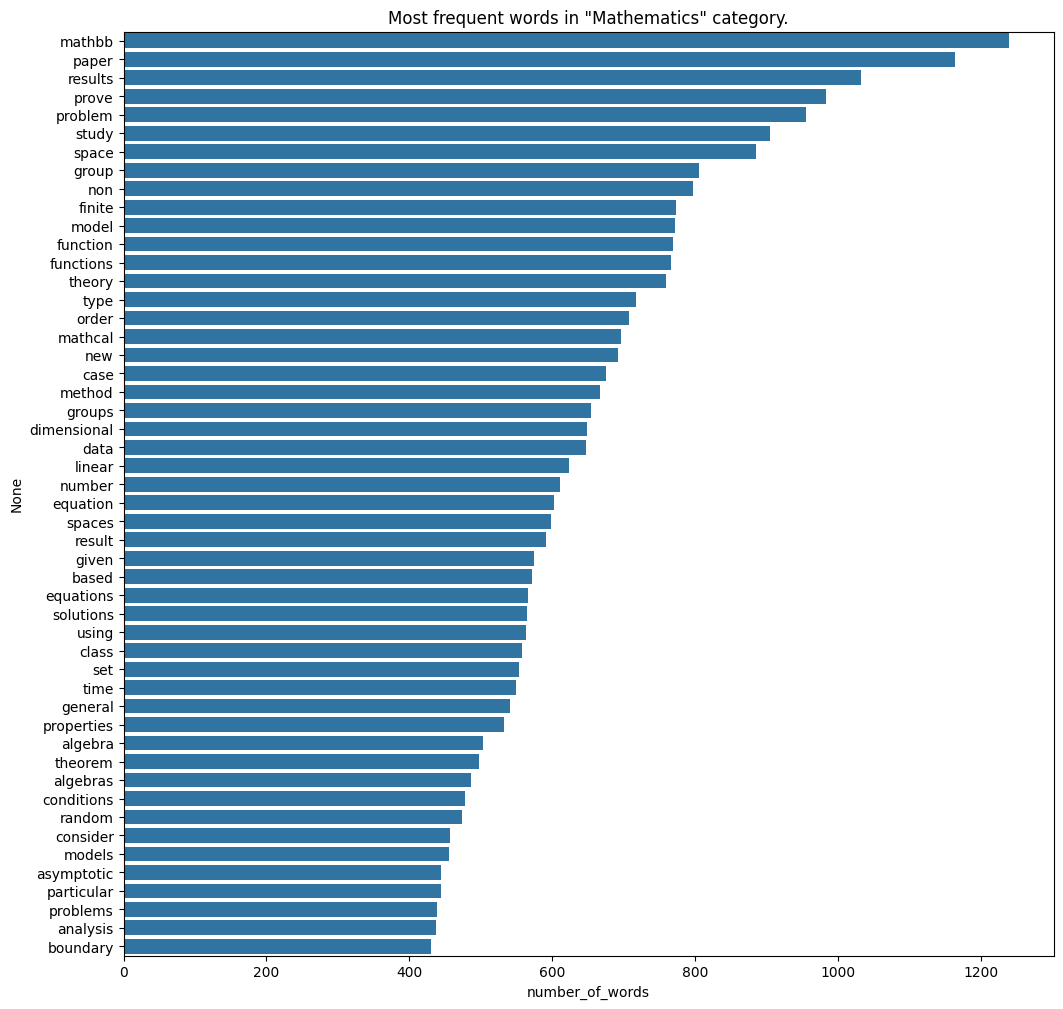

In [52]:
top_50_mt = top_50_counter(maths['text'])
top_50_barplot(top_50_mt, 'number_of_words', 'Most frequent words in "Mathematics" category.')

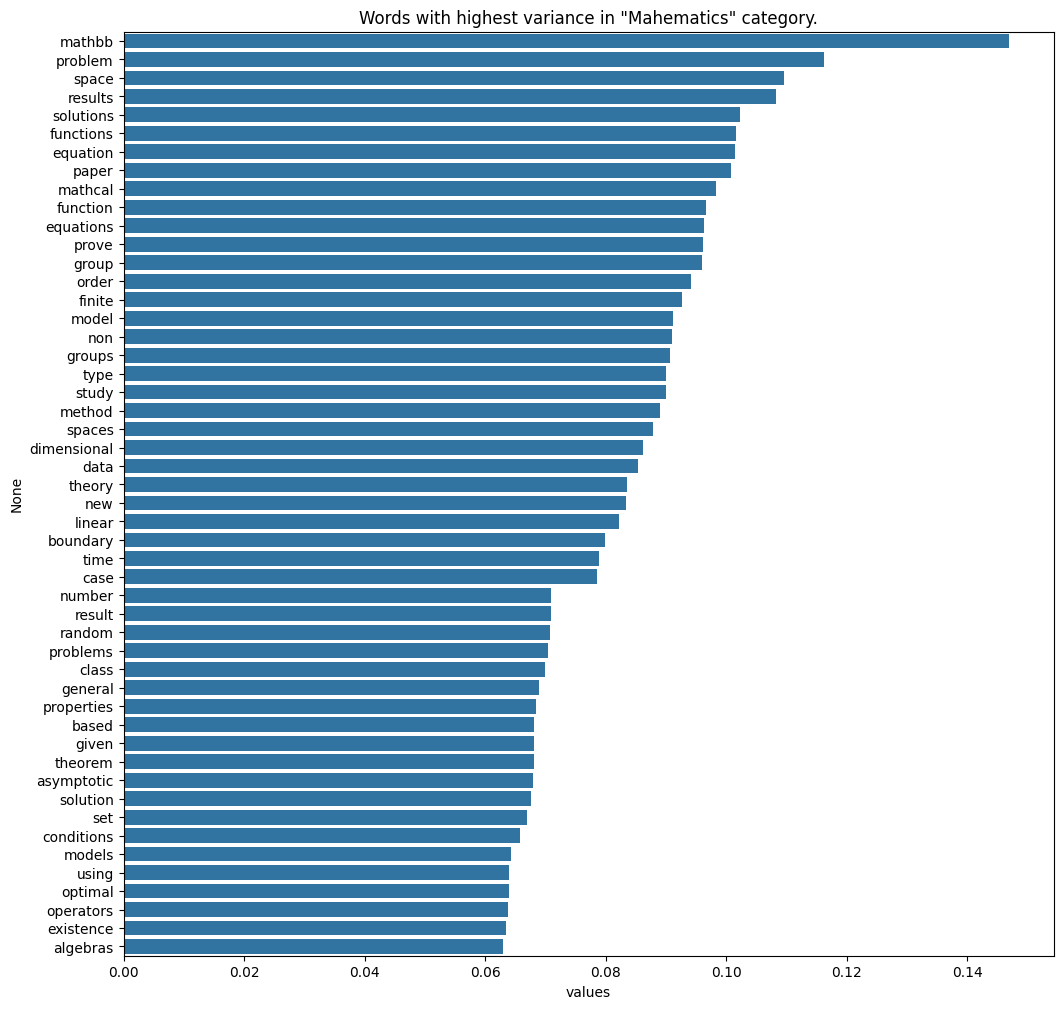

In [53]:
components_importance_plot(maths['text'], 'Words with highest variance in "Mahematics" category.')

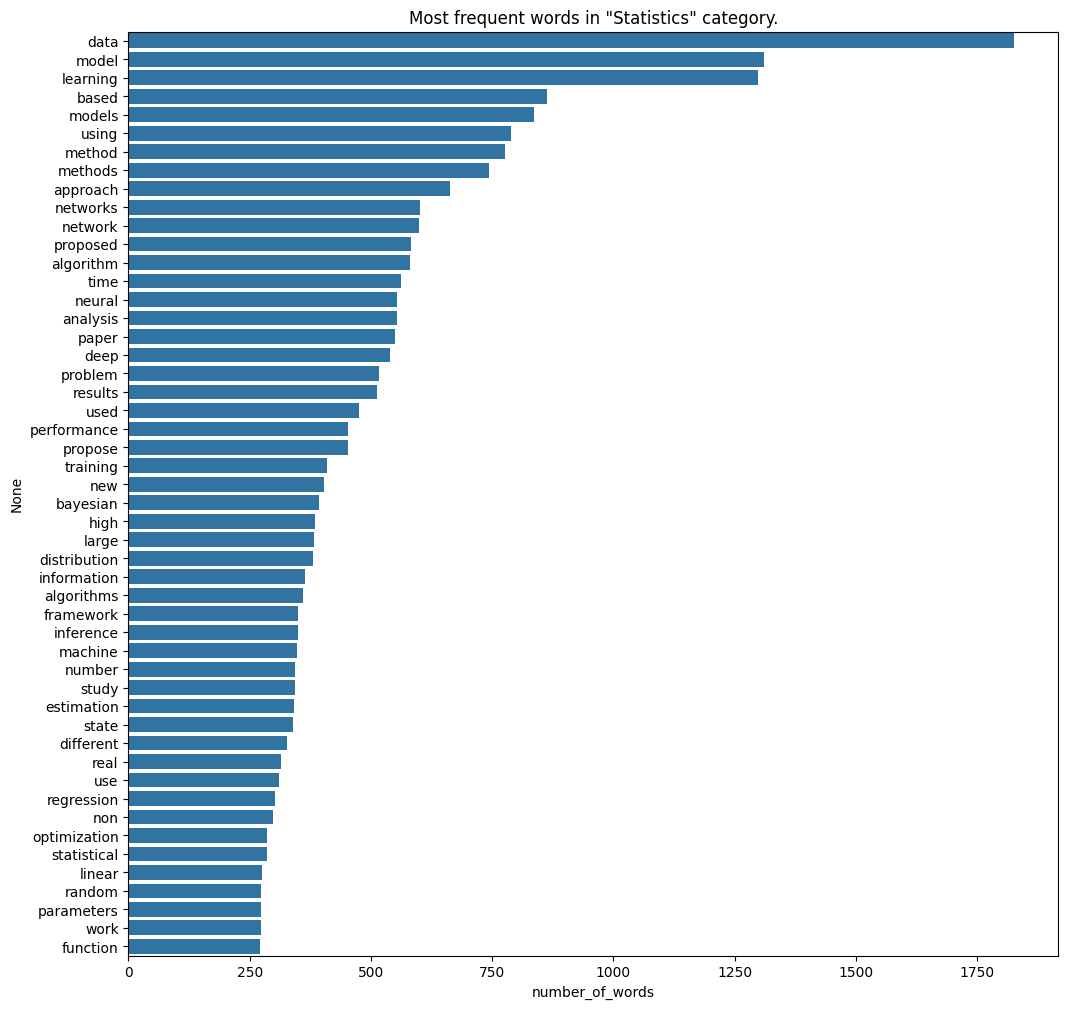

In [54]:
top_50_st = top_50_counter(stats['text'])
top_50_barplot(top_50_st, 'number_of_words', 'Most frequent words in "Statistics" category.')

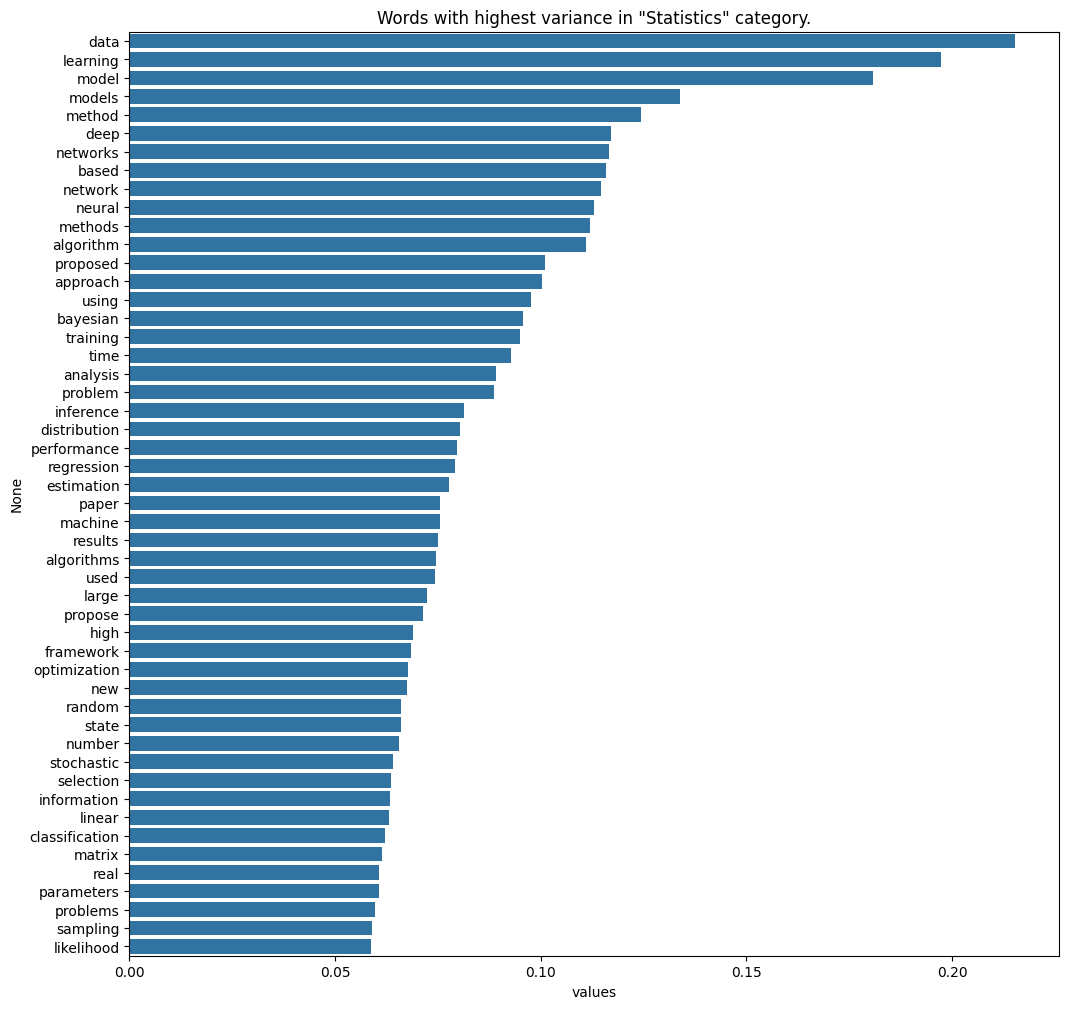

In [55]:
components_importance_plot(stats['text'], 'Words with highest variance in "Statistics" category.')

Stop for the moment on the 'Statostics' category - we can see some similarities with 'Computer science' category. 

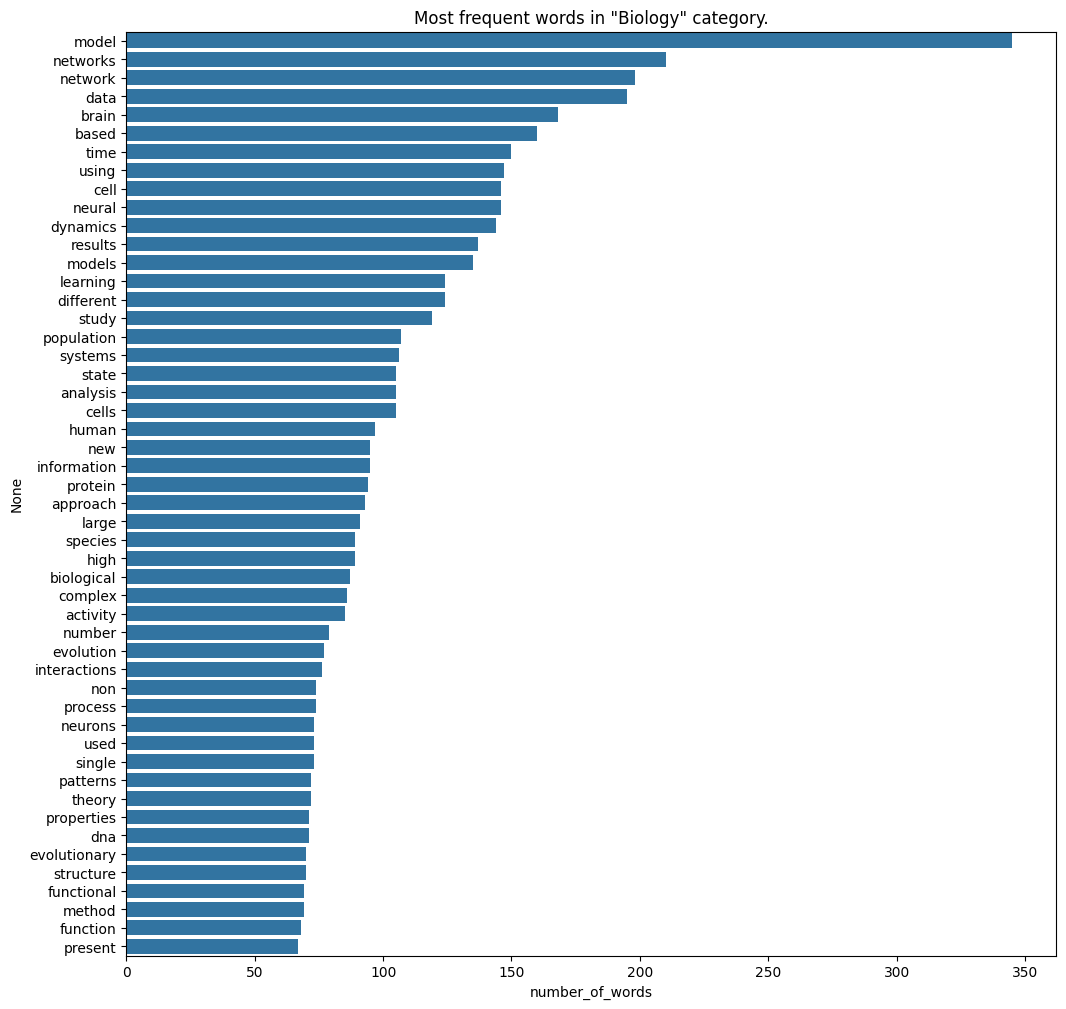

In [57]:
top_50_bl = top_50_counter(biology['text'])
top_50_barplot(top_50_bl, 'number_of_words', 'Most frequent words in "Biology" category.')

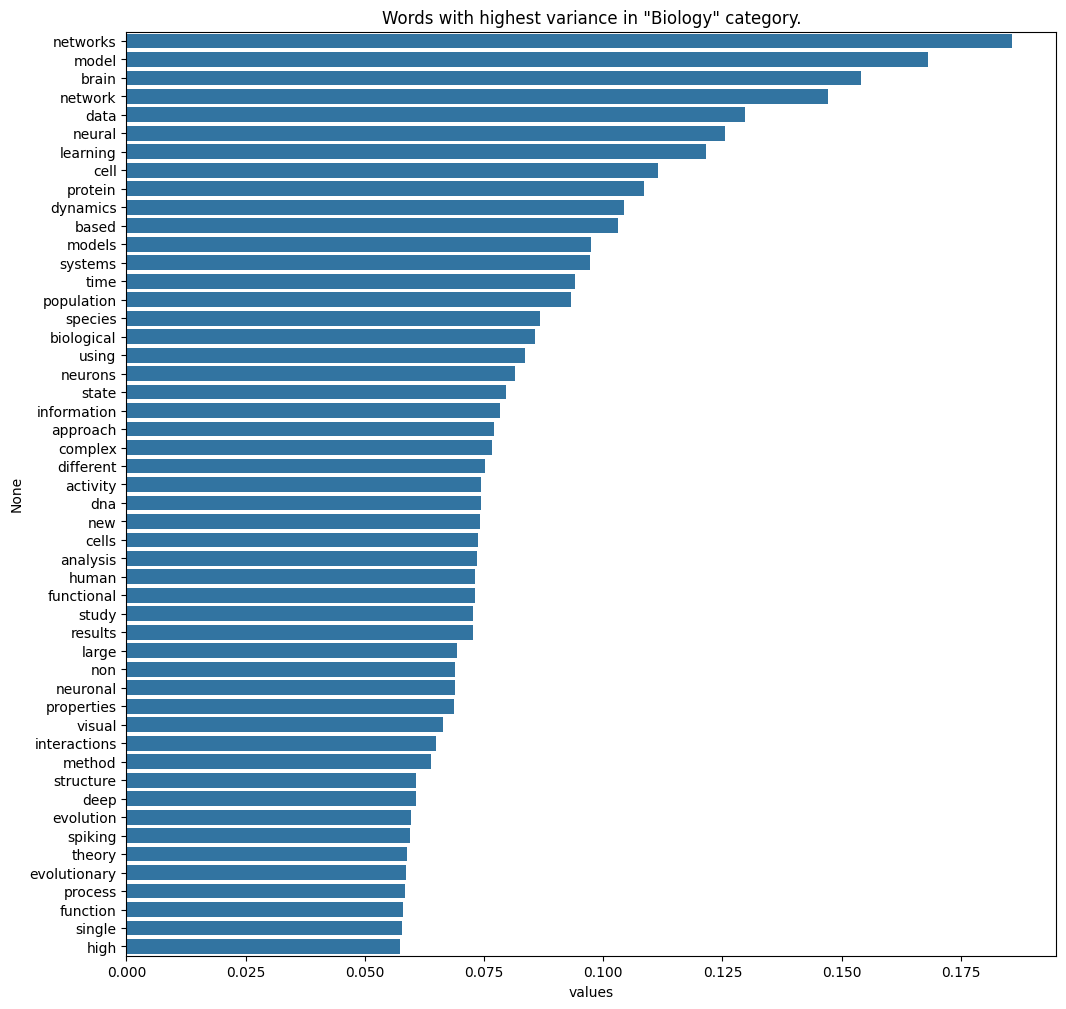

In [58]:
components_importance_plot(biology['text'], 'Words with highest variance in "Biology" category.')

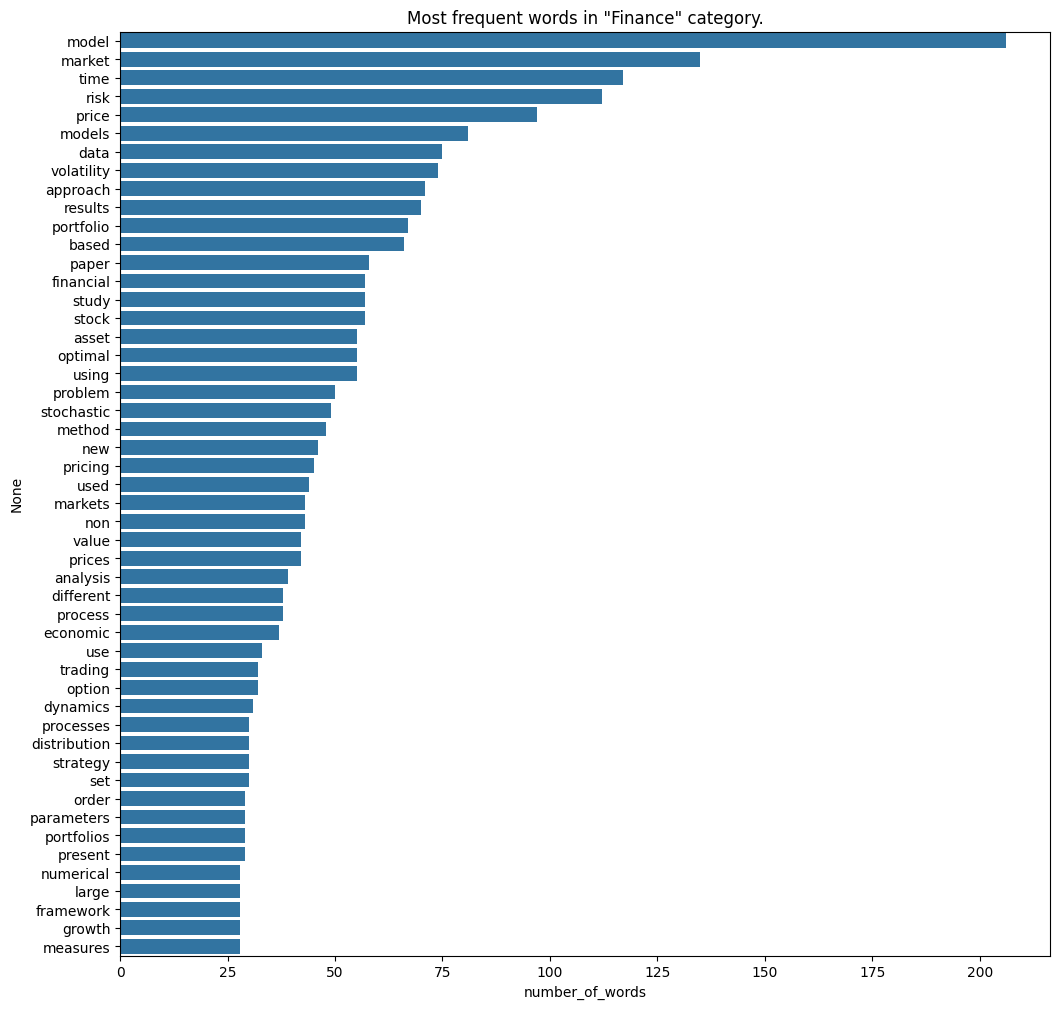

In [59]:
top_50_fin = top_50_counter(finance['text'])
top_50_barplot(top_50_fin, 'number_of_words', 'Most frequent words in "Finance" category.')

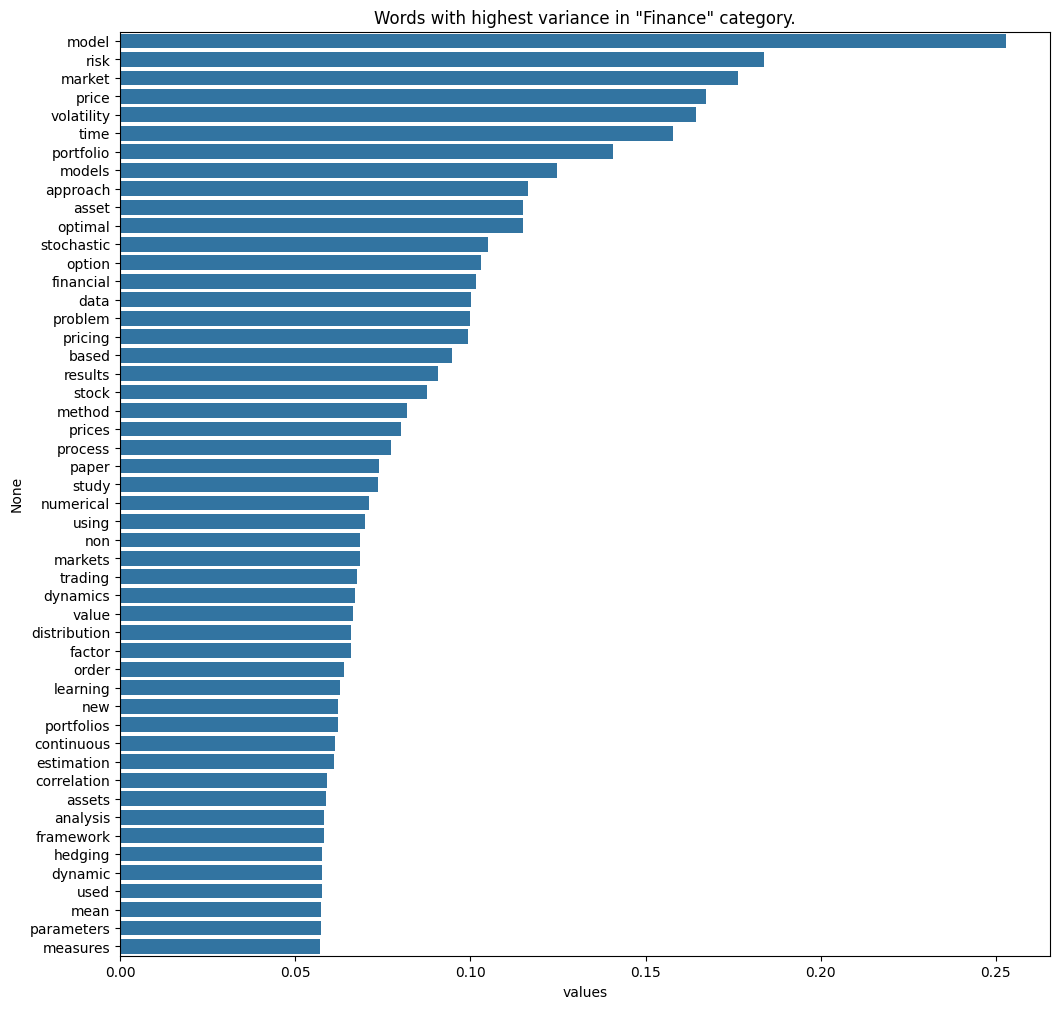

In [60]:
components_importance_plot(finance['text'], 'Words with highest variance in "Finance" category.')

<a id="3"></a> 
## 3. Data preprocess

Before we start modeling we should prepare our data for modeling. First I'll 'generalize' words with cutting their last few letters - our models will have less parameters, with higher importance. For this purpose I'll use two techniques: steming and lemmatization. 
Let's start with stemming:

In [63]:
stemmer = nltk.stem.SnowballStemmer('english', ignore_stopwords=True)

In [64]:
tokenized_articles = [nltk.tokenize.word_tokenize(art) for art in df['text']] # making tokens 

In [65]:
stemmed_articles = [[stemmer.stem(token) for token in art] for art in tokenized_articles] # using stemmer inside each record

In [66]:
joined_articles = [' '.join(art) for art in stemmed_articles] # joining article back into one string 

We can check effects:

In [68]:
joined_articles[0]

'detect the impact of public transit on the transmiss of epidem in mani develop countri , public transit play an import role in daili life . howev , few exist method have consid the influenc of public transit in their model . in this work , we present a dual-perspect view of the epidem spread process of the individu that involv both contamin in place ( such as work place and home ) and public transit ( such as buse and train ) . in more detail , we consid a group of individu who travel to some place use public transit , and introduc public transit into the epidem spread process . a novel model framework is propos consid place-bas infect and the public-transit-bas infect . in the urban scenario , we investig the public transit trip contribut rate ( pttcr ) in the epidem spread process of the individu , and assess the impact of the public transit trip contribut rate by evalu the volum of infecti peopl . scenario for strategi such as public transit and school closur were test and analyz .

As we can see some of the words got cut.

In [70]:
df['stemmed_text'] = joined_articles # making new column for Data Frame

Second technique is lemmatiation - this technique will be used in other types of models.

In [72]:
stopwords = nltk.corpus.stopwords.words('english') # defining stop worrds

In [73]:
df['edited_text'] = df['text'].apply(lambda x: gensim.utils.simple_preprocess(x)) # simpple preprocess from gensim libary 

In [74]:
df['edited_text'][1] #chcking effects of preprocessing

['detecting',
 'the',
 'impact',
 'of',
 'public',
 'transit',
 'on',
 'the',
 'transmission',
 'of',
 'epidemics',
 'in',
 'many',
 'developing',
 'countries',
 'public',
 'transit',
 'plays',
 'an',
 'important',
 'role',
 'in',
 'daily',
 'life',
 'however',
 'few',
 'existing',
 'methods',
 'have',
 'considered',
 'the',
 'influence',
 'of',
 'public',
 'transit',
 'in',
 'their',
 'models',
 'in',
 'this',
 'work',
 'we',
 'present',
 'dual',
 'perspective',
 'view',
 'of',
 'the',
 'epidemic',
 'spreading',
 'process',
 'of',
 'the',
 'individual',
 'that',
 'involves',
 'both',
 'contamination',
 'in',
 'places',
 'such',
 'as',
 'work',
 'places',
 'and',
 'homes',
 'and',
 'public',
 'transit',
 'such',
 'as',
 'buses',
 'and',
 'trains',
 'in',
 'more',
 'detail',
 'we',
 'consider',
 'group',
 'of',
 'individuals',
 'who',
 'travel',
 'to',
 'some',
 'places',
 'using',
 'public',
 'transit',
 'and',
 'introduce',
 'public',
 'transit',
 'into',
 'the',
 'epidemic',
 'spread

We can check lenght of the longest article:

In [76]:
max([len(art) for art in df['edited_text']])

399

Then delate stop words:

In [78]:
df['edited_text'] = [[token for token in article if token not in stopwords] for article in df['edited_text']]

In [79]:
df['edited_text'][1]

['detecting',
 'impact',
 'public',
 'transit',
 'transmission',
 'epidemics',
 'many',
 'developing',
 'countries',
 'public',
 'transit',
 'plays',
 'important',
 'role',
 'daily',
 'life',
 'however',
 'existing',
 'methods',
 'considered',
 'influence',
 'public',
 'transit',
 'models',
 'work',
 'present',
 'dual',
 'perspective',
 'view',
 'epidemic',
 'spreading',
 'process',
 'individual',
 'involves',
 'contamination',
 'places',
 'work',
 'places',
 'homes',
 'public',
 'transit',
 'buses',
 'trains',
 'detail',
 'consider',
 'group',
 'individuals',
 'travel',
 'places',
 'using',
 'public',
 'transit',
 'introduce',
 'public',
 'transit',
 'epidemic',
 'spreading',
 'process',
 'novel',
 'modeling',
 'framework',
 'proposed',
 'considering',
 'place',
 'based',
 'infections',
 'public',
 'transit',
 'based',
 'infections',
 'urban',
 'scenario',
 'investigate',
 'public',
 'transit',
 'trip',
 'contribution',
 'rate',
 'pttcr',
 'epidemic',
 'spreading',
 'process',
 'indiv

In [80]:
max([len(art) for art in df['edited_text']])

229

As we can see longest article is much shorter after this operation.

Now we can start lemmatization:

In [82]:
lemmatizer = nltk.stem.WordNetLemmatizer()

In [83]:
df['edited_text'] = [[lemmatizer.lemmatize(token) for token in article] for article in df['edited_text']]

In [84]:
df['edited_text'][1]

['detecting',
 'impact',
 'public',
 'transit',
 'transmission',
 'epidemic',
 'many',
 'developing',
 'country',
 'public',
 'transit',
 'play',
 'important',
 'role',
 'daily',
 'life',
 'however',
 'existing',
 'method',
 'considered',
 'influence',
 'public',
 'transit',
 'model',
 'work',
 'present',
 'dual',
 'perspective',
 'view',
 'epidemic',
 'spreading',
 'process',
 'individual',
 'involves',
 'contamination',
 'place',
 'work',
 'place',
 'home',
 'public',
 'transit',
 'bus',
 'train',
 'detail',
 'consider',
 'group',
 'individual',
 'travel',
 'place',
 'using',
 'public',
 'transit',
 'introduce',
 'public',
 'transit',
 'epidemic',
 'spreading',
 'process',
 'novel',
 'modeling',
 'framework',
 'proposed',
 'considering',
 'place',
 'based',
 'infection',
 'public',
 'transit',
 'based',
 'infection',
 'urban',
 'scenario',
 'investigate',
 'public',
 'transit',
 'trip',
 'contribution',
 'rate',
 'pttcr',
 'epidemic',
 'spreading',
 'process',
 'individual',
 'assess

Differences are less visable than in stemming, but still they exist.

<a id="4"></a> 
## 4. Spliting datasets

Because I want to check is the stemming really affect into models performance I will not delete column with primary text. I will chec the difference and keep column with is better.

For modelling we will divide columns into data and label calumn, split dataset into to sets - training set, and testing set, and divide columns into each techniques which will be used. 

In [88]:
X = df.drop('label', axis=1)
y = df['label']

In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

In [90]:
X_train_text = X_train['text'] # primary data
X_test_text = X_test['text']
X_train_stem = X_train['stemmed_text'] # stemmed data
X_test_stem = X_test['stemmed_text']
X_train_w2v = X_train['edited_text'] # data lemmatuzed and with delated stop words
X_test_w2v = X_test['edited_text']

Take a look on the effects of our preprocessing for echach type of edition:

In [92]:
X_train_text.head()

ID
8165     Latent Association Mining in Binary Data   We ...
4217     Global Symmetries, Counterterms, and Duality i...
13327    The Rabi frequency on the $H^3Δ_1$ to $C^1Π$ t...
15087    Pulsejet engine dynamics in vertical motion us...
10980    The Godunov Method for a 2-Phase Model   We co...
Name: text, dtype: object

In [93]:
X_train_stem.head()

ID
8165     latent associ mine in binari data we consid th...
4217     global symmetri , counterterm , and dualiti in...
13327    the rabi frequenc on the $ h^3δ_1 $ to $ c^1π ...
15087    pulsejet engin dynam in vertic motion use mome...
10980    the godunov method for a 2-phase model we cons...
Name: stemmed_text, dtype: object

In [94]:
X_train_w2v.head()

ID
8165     [latent, association, mining, binary, data, co...
4217     [global, symmetry, counterterms, duality, cher...
13327    [rabi, frequency, δ_, transition, tho, influen...
15087    [pulsejet, engine, dynamic, vertical, motion, ...
10980    [godunov, method, phase, model, consider, godu...
Name: edited_text, dtype: object

<a id="5"></a> 
## 5. Modelling using Word2Vec

As we know Machine Learning models for modelling need numbers not words - so we need to change words into numbers. But how to make it? One of the techniques which I'll use is Word2Vec. This technique is changing words into vectors - for that purpose it needs training.
There will be used two types of vectors - trained on data, and pretrained.

<a id="6"></a> 
### 1. Model trained on training data

Let's start tto train our vectors, on our training data:

In [99]:
w2v_model = gensim.models.Word2Vec(X_train_w2v, vector_size=300, window=5, min_count=2) # vector size 300 because its little bit longer than longest record

For checking effects of training I'll check similarities of few words (most frequent and categories names):

In [101]:
w2v_model.wv.most_similar('mathematics')

[('economics', 0.9226550459861755),
 ('aerospace', 0.909379780292511),
 ('discipline', 0.9092468619346619),
 ('achievement', 0.9054296016693115),
 ('longstanding', 0.8959156274795532),
 ('mind', 0.8942967653274536),
 ('playground', 0.8938583135604858),
 ('bci', 0.8936024904251099),
 ('persuasive', 0.892537534236908),
 ('broaden', 0.8917030096054077)]

In [102]:
w2v_model.wv.most_similar('computer')

[('vision', 0.9493343234062195),
 ('robotics', 0.9026995897293091),
 ('ai', 0.8881859183311462),
 ('engineering', 0.8849435448646545),
 ('modern', 0.884124755859375),
 ('intelligence', 0.8731793165206909),
 ('iot', 0.868533194065094),
 ('science', 0.8641641736030579),
 ('advanced', 0.8611786961555481),
 ('endeavor', 0.8607033491134644)]

In [103]:
w2v_model.wv.most_similar('finance')

[('technological', 0.9518916606903076),
 ('prototyping', 0.949623703956604),
 ('industrial', 0.9493201971054077),
 ('medicine', 0.9464743137359619),
 ('neuroscience', 0.9460477828979492),
 ('invite', 0.9422057867050171),
 ('economics', 0.9417820572853088),
 ('academic', 0.9417362213134766),
 ('healthcare', 0.9413363337516785),
 ('assistive', 0.9411330223083496)]

In [104]:
w2v_model.wv.most_similar('model')

[('gp', 0.6303730010986328),
 ('logistic', 0.6184271574020386),
 ('heteroscedastic', 0.6101536750793457),
 ('probit', 0.5925537943840027),
 ('inference', 0.5846439003944397),
 ('ame', 0.5803101062774658),
 ('vde', 0.579848051071167),
 ('predictor', 0.5763692855834961),
 ('glm', 0.5734671950340271),
 ('nonparametrics', 0.5715757608413696)]

In [105]:
w2v_model.wv.most_similar('data')

[('recalibration', 0.6167345643043518),
 ('trial', 0.6148121356964111),
 ('eeg', 0.6136873364448547),
 ('sentinel', 0.6116978526115417),
 ('recist', 0.5959410667419434),
 ('polsar', 0.5772265791893005),
 ('netflix', 0.576173722743988),
 ('communicated', 0.5750535130500793),
 ('typically', 0.5742678642272949),
 ('muser', 0.5714723467826843)]

Because classical Machine Learning algorithms need 2D arrays for processing we need to make few techniques to prepare data:

In [107]:
words = set(w2v_model.wv.index_to_key) # preparing set of unique words in our w2v model

In [108]:
X_train_w2v.shape # size of dataset

(12777,)

In [109]:
X_train_vect = [] # creating new list with vectorized articles 
for art in X_train_w2v:
    art_array = [] # every single article has its own list 
    for token in art:
        if token in words:
            art_array.append(w2v_model.wv[token]) # adding token's vector into the list
    X_train_vect.append(np.array(art_array)) # adding array into the list
            

Le'ts check the result of our operation on single article, and single token:

In [111]:
X_train_vect[0]

array([[-0.17166938,  0.557554  , -0.38603407, ..., -1.6348774 ,
         0.20917319,  0.64401984],
       [-0.17430034,  0.18572937, -0.09426892, ..., -0.475387  ,
         0.3276371 , -0.2004795 ],
       [-0.39512873,  0.29642203, -0.42024937, ..., -0.7172348 ,
         0.35300493, -0.18200919],
       ...,
       [-0.30386692,  0.26297235,  0.8341125 , ...,  0.27031168,
        -0.4384649 , -0.26602867],
       [-0.08219198,  1.3093544 ,  0.12025336, ..., -1.4776475 ,
        -0.26836994, -0.8996188 ],
       [-0.21168037, -0.19577867,  0.06395202, ..., -0.02983795,
         0.7475442 ,  0.5692105 ]], dtype=float32)

In [112]:
X_train_vect[0][0]

array([-0.17166938,  0.557554  , -0.38603407,  0.1326622 , -0.5225805 ,
        0.11106818,  0.5554565 ,  0.59210646, -0.19125712, -0.6529061 ,
        0.9348343 ,  0.26375282,  0.28755298, -0.9658426 ,  0.13904887,
       -0.2725516 ,  0.5368382 ,  0.04730873, -0.32211468, -0.06729978,
        1.1336669 ,  0.3076473 ,  0.30921647, -0.67982143, -0.01247887,
        0.07699771, -0.5050586 ,  0.4241416 , -0.32416278, -1.1055616 ,
        0.87157017,  0.48419413, -0.08275387,  0.46043578, -0.08718204,
       -0.29802424,  0.5323511 , -0.15158895, -0.44324923,  0.41986763,
        0.01382452, -0.79920727,  0.01525106, -0.2768778 ,  0.31558558,
       -0.8554365 ,  0.5396698 ,  0.10613408,  0.7090243 ,  0.31946135,
       -0.41905978, -0.2706022 , -0.84576875,  0.46401507, -0.25027427,
        0.54997003,  0.84048295,  0.6405948 , -0.00356316, -0.5412308 ,
        0.23953307, -0.04125452,  0.47779712, -0.5297071 , -0.01909524,
       -0.21208695,  0.1940583 ,  0.55505973, -0.26948637, -0.13

As I said before - we need 2d array, so my idea to make features is to use mean of the vector:

In [114]:
X_train_vect_avg = [] 
for v in X_train_vect: 
    if v.size: 
        X_train_vect_avg.append(v.mean(axis=0))  # average of the vector
    else: 
        X_train_vect_avg.append(np.zeros(300, dtype=float)) # inputing eros if size of vector doesn't fit

In [115]:
len(X_train_vect_avg) # checking size of the list 

12777

In [116]:
X_train_vect_avg[0].shape # checking size of first record

(300,)

Let's make the sdame operations with our test set:

In [118]:
X_test_vect = []
for art in X_test_w2v:
    art_array = []
    for token in art:
        if token in words:
            art_array.append(w2v_model.wv[token]) # model is still trained on our training set
    X_test_vect.append(np.array(art_array))            

In [119]:
X_test_vect_avg = [] 
for v in X_test_vect: 
    if v.size: 
        X_test_vect_avg.append(v.mean(axis=0)) 
    else: 
        X_test_vect_avg.append(np.zeros(300, dtype=float))

For simple checking what type of data preparation is better I'll test three different types of algirythms in their default hyperparameters:

- Logistic Regression
- Decission Tree Classifier
- KNN Classifier

Another idea what I will check is to test how much time each algotithm is taking to calculate results. Here we go:

In [121]:
start_time = time.time()
lr = LogisticRegression()
lr.fit(X_train_vect_avg, y_train)
preds = lr.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1308
           1       0.89      0.86      0.88       841
           2       0.79      0.83      0.81       670
           3       0.46      0.20      0.28       276
           4       0.41      0.10      0.16        68
           5       0.50      0.09      0.16        32

    accuracy                           0.79      3195
   macro avg       0.64      0.50      0.52      3195
weighted avg       0.77      0.79      0.77      3195

Execution time is 0.66 seconds.


In [122]:
start_time = time.time()
dt = DecisionTreeClassifier()
dt.fit(X_train_vect_avg, y_train)
preds = dt.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1308
           1       0.82      0.81      0.81       841
           2       0.71      0.70      0.71       670
           3       0.28      0.30      0.29       276
           4       0.17      0.18      0.18        68
           5       0.08      0.06      0.07        32

    accuracy                           0.69      3195
   macro avg       0.47      0.46      0.47      3195
weighted avg       0.69      0.69      0.69      3195

Execution time is 7.01 seconds.


In [123]:
start_time = time.time()
knn = KNeighborsClassifier()
knn.fit(X_train_vect_avg, y_train)
preds = knn.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.88      0.81      1308
           1       0.89      0.85      0.87       841
           2       0.79      0.78      0.79       670
           3       0.37      0.22      0.27       276
           4       0.47      0.12      0.19        68
           5       0.38      0.09      0.15        32

    accuracy                           0.77      3195
   macro avg       0.61      0.49      0.51      3195
weighted avg       0.75      0.77      0.75      3195

Execution time is 0.44 seconds.


With this short test we can see that Logistic Regression is giving best results. Also it is quite quick - it is taking less than one second to give results. Later, after choosing best vectorizing method I will try to use another models. At leas we can see first problem - first, largest classes are predicted quite well, but rest of them not.

<a id="7"></a> 
### 2. Using pretrained vectors

Another method for applying is to use pretrained vectors. For that task i used vectors from 'glove-wiki-gigaword-300', where vectors are trained on wikedia.

Let's load set and wpply the same operations:

In [127]:
wiki_vectors = api.load('glove-wiki-gigaword-300')

In [128]:
wiki_words = set(wiki_vectors.index_to_key)

In [129]:
wiki_vectors.most_similar('statistics') # here I'll just look for most similar words for word 'statistics'

[('figures', 0.6141332387924194),
 ('statistic', 0.6047859191894531),
 ('data', 0.5523297190666199),
 ('according', 0.5400314927101135),
 ('statistical', 0.5245029926300049),
 ('bureau', 0.5203931927680969),
 ('census', 0.5157347917556763),
 ('estimates', 0.5040061473846436),
 ('numbers', 0.5007869601249695),
 ('report', 0.48648926615715027)]

Preparation of dataset:

In [131]:
X_train_vect_wiki = []
for art in X_train_w2v:
    art_array = []
    for token in art:
        if token in wiki_words:
            art_array.append(wiki_vectors[token])
    X_train_vect_wiki.append(np.array(art_array))
            

In [132]:
X_test_vect_wiki = []
for art in X_test_w2v:
    art_array = []
    for token in art:
        if token in wiki_words:
            art_array.append(wiki_vectors[token])
    X_test_vect_wiki.append(np.array(art_array))
            

In [133]:
X_train_vect_wiki_avg = [] 
for v in X_train_vect_wiki: 
    if v.size: 
        X_train_vect_wiki_avg.append(v.mean(axis=0)) 
    else: 
        X_train_vect_wiki_avg.append(np.zeros(300, dtype=float))

In [134]:
X_test_vect_wiki_avg = [] 
for v in X_test_vect_wiki: 
    if v.size: 
        X_test_vect_wiki_avg.append(v.mean(axis=0)) 
    else: 
        X_test_vect_wiki_avg.append(np.zeros(300, dtype=float))

Predicting:

In [136]:
start_time = time.time()
lr.fit(X_train_vect_wiki_avg, y_train)
preds = lr.predict(X_test_vect_wiki_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1308
           1       0.90      0.85      0.87       841
           2       0.79      0.80      0.79       670
           3       0.47      0.21      0.29       276
           4       0.61      0.37      0.46        68
           5       0.82      0.56      0.67        32

    accuracy                           0.79      3195
   macro avg       0.72      0.61      0.65      3195
weighted avg       0.78      0.79      0.77      3195

Execution time is 0.61 seconds.


In [137]:
start_time = time.time()
dt.fit(X_train_vect_wiki_avg, y_train)
preds = dt.predict(X_test_vect_wiki_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.67      0.69      0.68      1308
           1       0.71      0.70      0.71       841
           2       0.62      0.56      0.59       670
           3       0.17      0.18      0.18       276
           4       0.11      0.09      0.10        68
           5       0.10      0.12      0.11        32

    accuracy                           0.61      3195
   macro avg       0.40      0.39      0.39      3195
weighted avg       0.61      0.61      0.61      3195

Execution time is 5.67 seconds.


In [138]:
start_time = time.time()
knn.fit(X_train_vect_wiki_avg, y_train)
preds = knn.predict(X_test_vect_wiki_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.72      0.90      0.80      1308
           1       0.88      0.85      0.86       841
           2       0.82      0.66      0.73       670
           3       0.32      0.21      0.25       276
           4       0.59      0.24      0.34        68
           5       0.90      0.28      0.43        32

    accuracy                           0.76      3195
   macro avg       0.71      0.52      0.57      3195
weighted avg       0.75      0.76      0.74      3195

Execution time is 0.27 seconds.


As we can see vectors trained on training set are giving better results - differences are not very high, but still they exist. I will use this type of vectorization for futute fredictions, but with two exceptions.

<a id="8"></a> 
### 3. Bidirectional LSTM model

First exception will be usage of Neural Network with LSTM layers inside. Because dataset should be prepared differently than for other models I'll just use that method as an 'bonus' stage.

First we need to prepare the data:

In [142]:
num_words = 30000 # number of tokens
tokenizer=Tokenizer(num_words)
X_train_pre = [' '.join(art) for art in X_train_w2v] # 'cancelling' tokenization
X_test_pre = [' '.join(art) for art in X_test_w2v]
X_total = X_train_pre + X_test_pre # for that purpose we need all of the words which we will use
tokenizer.fit_on_texts(X_total) # making new token set

In [143]:
X_train_ker = tokenizer.texts_to_sequences(X_train_pre) # creating seqyuneces
X_train_pad = pad_sequences(X_train_ker, maxlen=300, padding='post') # padding sequences - to have the same lenght
X_test_ker = tokenizer.texts_to_sequences(X_test_pre)
X_test_pad = pad_sequences(X_test_ker, maxlen=300, padding='post')

In [144]:
vector_size = 300 # size of the vector 
gensim_weight_matrix = np.zeros((num_words ,vector_size)) # zero matrix with weights for embeddings
for word, index in tokenizer.word_index.items():
    if index < num_words: # cutting number of words
        if word in wiki_words:
            gensim_weight_matrix[index] = wiki_vectors[word] # adding vectors to weights
        else:
            gensim_weight_matrix[index] = np.zeros(300) # vector with zeros if word is not in our set of tokens

In [145]:
y_train_ker = to_categorical(y_train) # changing label column into type which will fit for neural networks
y_test_ker = to_categorical(y_test)

In [146]:
EMBEDDING_DIM = 300
class_num = 6
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False)) # enbedding layer with weights from w2v
model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(Bidirectional(LSTM(256,return_sequences=True)))
model.add(Bidirectional(LSTM(128,return_sequences=False)))
model.add(Dense(128, activation='relu'))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [147]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 5)

In [148]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          9000000   
                                                                 
 bidirectional (Bidirection  (None, 300, 256)          439296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 512)          1050624   
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 256)               656384    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                        

As we can see we have 9 million parameters, and 6 layers. 

In [150]:
history_embedding = model.fit(X_train_pad, y_train_ker, 
                                epochs = 25, batch_size = 128, 
                                validation_split=0.1,
                                verbose = 1, callbacks= [es]  )

Epoch 1/25
90/90 [==============================] - 2246s 25s/step - loss: 0.8168 - accuracy: 0.7314 - val_loss: 0.7130 - val_accuracy: 0.7637
Epoch 2/25
90/90 [==============================] - 2416s 27s/step - loss: 0.6455 - accuracy: 0.7789 - val_loss: 0.6148 - val_accuracy: 0.7825
Epoch 3/25
90/90 [==============================] - 2600s 29s/step - loss: 0.5906 - accuracy: 0.7893 - val_loss: 0.6228 - val_accuracy: 0.7840
Epoch 4/25
90/90 [==============================] - 2683s 30s/step - loss: 0.5557 - accuracy: 0.7997 - val_loss: 0.5899 - val_accuracy: 0.7903
Epoch 5/25
90/90 [==============================] - 2771s 31s/step - loss: 0.4927 - accuracy: 0.8214 - val_loss: 0.5745 - val_accuracy: 0.7911
Epoch 6/25
90/90 [==============================] - 2814s 31s/step - loss: 0.4543 - accuracy: 0.8330 - val_loss: 0.6115 - val_accuracy: 0.7879
Epoch 7/25
90/90 [==============================] - 2808s 31s/step - loss: 0.4271 - accuracy: 0.8384 - val_loss: 0.6232 - val_accuracy: 0.7950

In [151]:
y_pred =   np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test_ker, axis=1)
print(classification_report(y_true, y_pred))

100/100 [==============================] - 102s 992ms/step
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1308
           1       0.94      0.83      0.88       841
           2       0.77      0.77      0.77       670
           3       0.35      0.22      0.27       276
           4       0.55      0.49      0.52        68
           5       0.44      0.53      0.48        32

    accuracy                           0.77      3195
   macro avg       0.63      0.62      0.62      3195
weighted avg       0.76      0.77      0.76      3195



Performance of neural network with LSTM layers, as it casn be seen is similar to simplest Machine Learning models. 

<a id="9"></a> 
### 4. Conv1D model

Anoher option how to predict sequences is to use Convolutional Layers. For this purpose I'll use 3 convolutional layers, combined with Max Pooling layers. 

In [155]:
model = Sequential()
model.add(Embedding(input_dim = num_words,
 output_dim = EMBEDDING_DIM,
 input_length= X_train_pad.shape[1],
 weights = [gensim_weight_matrix],trainable = False))
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(class_num, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics = ['accuracy'])

In [156]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 300)          9000000   
                                                                 
 conv1d (Conv1D)             (None, 298, 128)          115328    
                                                                 
 max_pooling1d (MaxPooling1  (None, 149, 128)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 147, 256)          98560     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 73, 256)           0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 71, 128)          

Again we habe 9 million parameters.

In [158]:
history_embedding = model.fit(X_train_pad, y_train_ker, 
                                epochs = 25, batch_size = 128, 
                                validation_split=0.1,
                                verbose = 1, callbacks= [es]  )

Epoch 1/25
90/90 [==============================] - 11s 110ms/step - loss: 0.8317 - accuracy: 0.7094 - val_loss: 0.7175 - val_accuracy: 0.7582
Epoch 2/25
90/90 [==============================] - 10s 110ms/step - loss: 0.6253 - accuracy: 0.7844 - val_loss: 0.6243 - val_accuracy: 0.7840
Epoch 3/25
90/90 [==============================] - 10s 114ms/step - loss: 0.5471 - accuracy: 0.8049 - val_loss: 0.5964 - val_accuracy: 0.7958
Epoch 4/25
90/90 [==============================] - 10s 110ms/step - loss: 0.4584 - accuracy: 0.8316 - val_loss: 0.6138 - val_accuracy: 0.7739
Epoch 5/25
90/90 [==============================] - 10s 110ms/step - loss: 0.3603 - accuracy: 0.8671 - val_loss: 0.6349 - val_accuracy: 0.7934
Epoch 6/25
90/90 [==============================] - 10s 111ms/step - loss: 0.2686 - accuracy: 0.8979 - val_loss: 0.7246 - val_accuracy: 0.7942
Epoch 7/25
90/90 [==============================] - 10s 111ms/step - loss: 0.1724 - accuracy: 0.9411 - val_loss: 0.8698 - val_accuracy: 0.7676

In [159]:
y_pred =   np.argmax(model.predict(X_test_pad), axis=1)
y_true = np.argmax(y_test_ker, axis=1)
print(classification_report(y_true, y_pred))

100/100 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1308
           1       0.87      0.84      0.86       841
           2       0.67      0.89      0.77       670
           3       0.28      0.17      0.21       276
           4       0.47      0.28      0.35        68
           5       0.59      0.41      0.48        32

    accuracy                           0.75      3195
   macro avg       0.62      0.56      0.58      3195
weighted avg       0.74      0.75      0.74      3195



As we can see Neural Network with convolutional layers has worse performance. But advantage of this type of training is that it is taking less time for training. 

<a id="10"></a> 
## 6. Modeling using Tfidf

Diffrent method for 'producing' features is to use Tfidf method. For that purpose I'll use full set of parameters, and data after stemming.

<a id="11"></a> 
### 1. Data without stemming

In [164]:
tfidf_1 = TfidfVectorizer(stop_words='english') # to not include stop words
start_time = time.time()
tfidf_text_lr_pipe = Pipeline([('tfidf', tfidf_1), ('lr', lr)])
tfidf_text_lr_pipe.fit(X_train_text, y_train)
preds = tfidf_text_lr_pipe.predict(X_test_text)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.91      0.88      0.89       841
           2       0.82      0.83      0.82       670
           3       0.48      0.19      0.27       276
           4       0.62      0.12      0.20        68
           5       0.75      0.19      0.30        32

    accuracy                           0.80      3195
   macro avg       0.72      0.52      0.55      3195
weighted avg       0.78      0.80      0.78      3195

Execution time is 4.09 seconds.


In [165]:
start_time = time.time()
tfidf_text_dt_pipe = Pipeline([('tfidf', tfidf_1), ('dt', dt)])
tfidf_text_dt_pipe.fit(X_train_text, y_train)
preds = tfidf_text_dt_pipe.predict(X_test_text)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.66      0.69      0.67      1308
           1       0.73      0.71      0.72       841
           2       0.64      0.65      0.64       670
           3       0.19      0.17      0.18       276
           4       0.11      0.09      0.10        68
           5       0.20      0.12      0.15        32

    accuracy                           0.62      3195
   macro avg       0.42      0.41      0.41      3195
weighted avg       0.62      0.62      0.62      3195

Execution time is 10.04 seconds.


In [166]:
start_time = time.time()
tfidf_text_knn_pipe = Pipeline([('tfidf', tfidf_1), ('knn', knn)])
tfidf_text_knn_pipe.fit(X_train_text, y_train)
preds = tfidf_text_knn_pipe.predict(X_test_text)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.71      0.88      0.79      1308
           1       0.87      0.82      0.85       841
           2       0.74      0.73      0.73       670
           3       0.44      0.14      0.22       276
           4       0.58      0.21      0.30        68
           5       0.67      0.31      0.43        32

    accuracy                           0.75      3195
   macro avg       0.67      0.52      0.55      3195
weighted avg       0.73      0.75      0.73      3195

Execution time is 12.61 seconds.


As we can see performance is similar, little bit better with logistic regression, but it's taking much more time for training.

<a id="12"></a> 
### 2. Stemmed data

In [169]:
start_time = time.time()
tfidf_stem_lr_pipe = Pipeline([('tfidf', tfidf_1), ('lr', lr)])
tfidf_stem_lr_pipe.fit(X_train_stem, y_train)
preds = tfidf_stem_lr_pipe.predict(X_test_stem)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1308
           1       0.90      0.88      0.89       841
           2       0.81      0.84      0.82       670
           3       0.49      0.19      0.27       276
           4       0.71      0.18      0.28        68
           5       0.75      0.28      0.41        32

    accuracy                           0.80      3195
   macro avg       0.74      0.54      0.58      3195
weighted avg       0.78      0.80      0.78      3195

Execution time is 3.47 seconds.


In [170]:
start_time = time.time()
tfidf_stem_dt_pipe = Pipeline([('tfidf', tfidf_1), ('dt', dt)])
tfidf_stem_dt_pipe.fit(X_train_stem, y_train)
preds = tfidf_stem_dt_pipe.predict(X_test_stem)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.68      0.70      0.69      1308
           1       0.76      0.71      0.73       841
           2       0.64      0.69      0.66       670
           3       0.23      0.21      0.22       276
           4       0.20      0.19      0.20        68
           5       0.18      0.12      0.15        32

    accuracy                           0.64      3195
   macro avg       0.45      0.44      0.44      3195
weighted avg       0.64      0.64      0.64      3195

Execution time is 8.62 seconds.


In [171]:
start_time = time.time()
tfidf_stem_knn_pipe = Pipeline([('tfidf', tfidf_1), ('knn', knn)])
tfidf_stem_knn_pipe.fit(X_train_stem, y_train)
preds = tfidf_stem_knn_pipe.predict(X_test_stem)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.70      0.89      0.78      1308
           1       0.88      0.80      0.84       841
           2       0.73      0.71      0.72       670
           3       0.36      0.11      0.17       276
           4       0.52      0.18      0.26        68
           5       0.80      0.25      0.38        32

    accuracy                           0.74      3195
   macro avg       0.67      0.49      0.53      3195
weighted avg       0.72      0.74      0.72      3195

Execution time is 10.94 seconds.


Stemming is not giving much on performanc, but i'st still litlle bit better than training on data without stemming. At least execution time is better, by using this method. For future predictions I'll use this method.

In [173]:
X_train_tfidf = tfidf_1.fit_transform(X_train_stem)
X_test_tfidf = tfidf_1.transform(X_test_stem)

<a id="13"></a> 
## 7. More models

Another models what i want to train on our data are:

- Suppurt Vector Machines
- Bagging Classifier (with linear regression - as the best simple model)
- XGBoost Clasifier
- LightGBM Classifier
- Random Forest
- Multinominal Naive Bayes
- Cat Boost Classifier

Let's start.

In [176]:
svm = SVC(probability=True)
bag = BaggingClassifier(random_state=123, estimator=lr)
xgb = XGBClassifier(random_state=123, eval_metric='mlogloss')
lgbm = LGBMClassifier(random_state=123, verbose=-1)
rf = RandomForestClassifier(random_state=123)
nb = MultinomialNB()
cat = CatBoostClassifier(random_state=123, verbose=False)

<a id="14"></a> 
### 1. Word2Vec

In [178]:
start_time = time.time()
svm.fit(X_train_vect_avg, y_train)
preds = svm.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.74      0.93      0.82      1308
           1       0.91      0.87      0.89       841
           2       0.81      0.82      0.81       670
           3       0.48      0.11      0.17       276
           4       1.00      0.07      0.14        68
           5       0.00      0.00      0.00        32

    accuracy                           0.79      3195
   macro avg       0.66      0.47      0.47      3195
weighted avg       0.77      0.79      0.76      3195

Execution time is 42.37 seconds.


In [179]:
start_time = time.time()
bag.fit(X_train_vect_avg, y_train)
preds = bag.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.89      0.82      1308
           1       0.89      0.86      0.88       841
           2       0.79      0.82      0.81       670
           3       0.45      0.20      0.28       276
           4       0.56      0.15      0.23        68
           5       0.50      0.09      0.16        32

    accuracy                           0.78      3195
   macro avg       0.66      0.50      0.53      3195
weighted avg       0.77      0.78      0.76      3195

Execution time is 7.24 seconds.


In [180]:
start_time = time.time()
xgb.fit(X_train_vect_avg, y_train)
preds = xgb.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.91      0.86      0.88       841
           2       0.80      0.81      0.81       670
           3       0.50      0.23      0.32       276
           4       0.48      0.15      0.22        68
           5       0.25      0.06      0.10        32

    accuracy                           0.79      3195
   macro avg       0.62      0.50      0.53      3195
weighted avg       0.78      0.79      0.78      3195

Execution time is 8.43 seconds.


In [181]:
start_time = time.time()
lgbm.fit(X_train_vect_avg, y_train)
preds = lgbm.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.91      0.86      0.88       841
           2       0.79      0.81      0.80       670
           3       0.49      0.22      0.30       276
           4       0.52      0.18      0.26        68
           5       0.67      0.12      0.21        32

    accuracy                           0.79      3195
   macro avg       0.69      0.52      0.55      3195
weighted avg       0.78      0.79      0.77      3195

Execution time is 6.19 seconds.


In [182]:
start_time = time.time()
rf.fit(X_train_vect_avg, y_train)
preds = rf.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1308
           1       0.90      0.86      0.88       841
           2       0.79      0.81      0.80       670
           3       0.48      0.16      0.24       276
           4       0.86      0.09      0.16        68
           5       0.00      0.00      0.00        32

    accuracy                           0.79      3195
   macro avg       0.63      0.47      0.48      3195
weighted avg       0.77      0.79      0.76      3195

Execution time is 26.55 seconds.


In [183]:
min_max = MinMaxScaler() # for Naive Bayes we need data above 0 
start_time = time.time()
pipeline = Pipeline([('minmax', min_max), ('nb', nb)])
pipeline.fit(X_train_vect_avg, y_train)
preds = pipeline.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.70      0.88      0.78      1308
           1       0.91      0.80      0.85       841
           2       0.72      0.83      0.77       670
           3       0.56      0.07      0.12       276
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        32

    accuracy                           0.75      3195
   macro avg       0.48      0.43      0.42      3195
weighted avg       0.72      0.75      0.71      3195

Execution time is 0.07 seconds.


In [184]:
start_time = time.time()
cat.fit(X_train_vect_avg, y_train)
preds = rf.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.74      0.91      0.82      1308
           1       0.90      0.86      0.88       841
           2       0.79      0.81      0.80       670
           3       0.48      0.16      0.24       276
           4       0.86      0.09      0.16        68
           5       0.00      0.00      0.00        32

    accuracy                           0.79      3195
   macro avg       0.63      0.47      0.48      3195
weighted avg       0.77      0.79      0.76      3195

Execution time is 76.55 seconds.


Again performance is very similar in most of the models.

<a id="15"></a> 
### 2. Tfidf

In [187]:
start_time = time.time()
svm.fit(X_train_tfidf, y_train)
preds = svm.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1308
           1       0.92      0.87      0.89       841
           2       0.81      0.84      0.82       670
           3       0.51      0.12      0.19       276
           4       0.62      0.15      0.24        68
           5       0.80      0.38      0.51        32

    accuracy                           0.80      3195
   macro avg       0.74      0.55      0.58      3195
weighted avg       0.78      0.80      0.77      3195

Execution time is 393.13 seconds.


In [188]:
start_time = time.time()
bag.fit(X_train_tfidf, y_train)
preds = bag.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1308
           1       0.90      0.88      0.89       841
           2       0.81      0.84      0.83       670
           3       0.48      0.18      0.26       276
           4       0.71      0.15      0.24        68
           5       0.80      0.25      0.38        32

    accuracy                           0.80      3195
   macro avg       0.74      0.53      0.57      3195
weighted avg       0.78      0.80      0.78      3195

Execution time is 23.22 seconds.


In [189]:
start_time = time.time()
xgb.fit(X_train_tfidf, y_train)
preds = xgb.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1308
           1       0.90      0.83      0.87       841
           2       0.80      0.82      0.81       670
           3       0.46      0.19      0.27       276
           4       0.77      0.25      0.38        68
           5       0.81      0.53      0.64        32

    accuracy                           0.79      3195
   macro avg       0.75      0.59      0.63      3195
weighted avg       0.78      0.79      0.77      3195

Execution time is 39.0 seconds.


In [190]:
start_time = time.time()
lgbm = LGBMClassifier(random_state=123, verbose=-1)
lgbm.fit(X_train_tfidf, y_train)
preds = lgbm.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1308
           1       0.91      0.85      0.88       841
           2       0.80      0.82      0.81       670
           3       0.48      0.21      0.30       276
           4       0.66      0.28      0.39        68
           5       0.76      0.41      0.53        32

    accuracy                           0.79      3195
   macro avg       0.73      0.58      0.62      3195
weighted avg       0.78      0.79      0.78      3195

Execution time is 12.91 seconds.


In [191]:
start_time = time.time()
rf.fit(X_train_tfidf, y_train)
preds = rf.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      1308
           1       0.91      0.82      0.87       841
           2       0.83      0.79      0.81       670
           3       0.67      0.01      0.01       276
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        32

    accuracy                           0.77      3195
   macro avg       0.52      0.43      0.41      3195
weighted avg       0.75      0.77      0.73      3195

Execution time is 28.34 seconds.


In [192]:
start_time = time.time()
nb.fit(X_train_tfidf, y_train)
preds = nb.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.64      0.98      0.77      1308
           1       0.94      0.81      0.87       841
           2       0.89      0.63      0.74       670
           3       0.00      0.00      0.00       276
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        32

    accuracy                           0.75      3195
   macro avg       0.41      0.40      0.40      3195
weighted avg       0.70      0.75      0.70      3195

Execution time is 0.02 seconds.


In [193]:
start_time = time.time()
cat.fit(X_train_tfidf, y_train)
preds = cat.predict(X_test_tfidf)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.89      0.81      1308
           1       0.88      0.84      0.86       841
           2       0.79      0.83      0.81       670
           3       0.44      0.15      0.22       276
           4       0.67      0.21      0.31        68
           5       0.76      0.41      0.53        32

    accuracy                           0.78      3195
   macro avg       0.71      0.55      0.59      3195
weighted avg       0.76      0.78      0.76      3195

Execution time is 463.52 seconds.


As we can see, performance again is similar. But we need to choose models to work - I'll choose Linear Regressoon, SVM, XGBoost, LGBM.

At least BaggingClassifier is giving better results, than busting algorythms - but in this case I've chosen them because of better F1 score.

<a id="16"></a> 
## 8. Dealing with imbalanced data

Another bonus in this project is usage of Imblearn libary for dealing with imbalanced dataset. Methods here will produce syntetic data for unrepresented classes.

I'll use:

- SMOTE
- BorderlineSMOTE
- ADASYN
- SMOTEENN 
- SMOTETomek
- SVMSmote

They will be trained with Logistic Regression.

In [197]:
smote = SMOTE()
bsmote = BorderlineSMOTE()
adasyn = ADASYN()
smoteenn = SMOTEENN()
smotetomek = SMOTETomek()
smote_s = SVMSMOTE()

In [198]:
imbl_models = [smote, bsmote, adasyn, smoteenn, smotetomek, smote_s]

<a id="17"></a> 
### 1. Word2Vec

In [200]:
for model in imbl_models:
    pipe = Pipeline([('imbl', model), ('lr', lr)])
    pipe.fit(X_train_vect_avg, y_train)
    preds = pipe.predict(X_test_vect_avg)
    class_rep = classification_report(y_test, preds)
    print(model, ' :')
    print(class_rep)
    print(" ")

SMOTE()  :
              precision    recall  f1-score   support

           0       0.85      0.60      0.70      1308
           1       0.91      0.82      0.86       841
           2       0.78      0.81      0.80       670
           3       0.29      0.50      0.37       276
           4       0.22      0.66      0.33        68
           5       0.13      0.62      0.22        32

    accuracy                           0.69      3195
   macro avg       0.53      0.67      0.55      3195
weighted avg       0.78      0.69      0.72      3195

 
BorderlineSMOTE()  :
              precision    recall  f1-score   support

           0       0.84      0.58      0.69      1308
           1       0.88      0.84      0.86       841
           2       0.74      0.83      0.78       670
           3       0.29      0.48      0.36       276
           4       0.24      0.57      0.34        68
           5       0.17      0.66      0.27        32

    accuracy                           0.69

<a id="18"></a> 
### 2. Tfidf

In [202]:
for model in imbl_models:
    pipe = Pipeline([('imbl', model), ('lr', lr)])
    pipe.fit(X_train_tfidf, y_train)
    preds = pipe.predict(X_test_tfidf)
    class_rep = classification_report(y_test, preds)
    print(model, ' :')
    print(class_rep)
    print(" ")

SMOTE()  :
              precision    recall  f1-score   support

           0       0.82      0.75      0.79      1308
           1       0.92      0.87      0.89       841
           2       0.80      0.84      0.82       670
           3       0.34      0.44      0.38       276
           4       0.46      0.62      0.52        68
           5       0.59      0.72      0.65        32

    accuracy                           0.77      3195
   macro avg       0.65      0.71      0.68      3195
weighted avg       0.79      0.77      0.78      3195

 
BorderlineSMOTE()  :
              precision    recall  f1-score   support

           0       0.83      0.75      0.79      1308
           1       0.91      0.89      0.90       841
           2       0.79      0.84      0.82       670
           3       0.35      0.45      0.39       276
           4       0.50      0.62      0.55        68
           5       0.58      0.69      0.63        32

    accuracy                           0.78

As we can see oversampling techniques on TFIDF is giving some results. F1 is better but accuracy is lower than without usage of those techniques. Problem still is that 'Statistics' label still has bad precission and recall.

<a id="19"></a> 
## 9. Hyperparameter tuning

This chapter will focus on tuning hyperparameters for chosen algorythms.

<a id="20"></a> 
### 1. Word2Vec

<a id="21"></a> 
#### 1. Logistic Regression

In [208]:
param_grid = {'C' : [0.1, 1, 10], 'solver': ['lbfgs', 'sag'], 'class_weight': [None, 'balanced'], 
              'multi_class': ['ovr', 'multinomial']}
# {'C' : [1], 'solver': ['sag'], 'class_weight': [None], 'multi_class': ['ovr']}
# {'C' : [0.1, 1, 10], 'solver': ['lbfgs', 'sag'], 'class_weight': [None, 'balanced'], 'multi_class': ['ovr', 'multinomial']}
w2v_lr_gs = GridSearchCV(lr, param_grid=param_grid, cv=5)
w2v_lr_gs.fit(X_train_vect_avg, y_train)
preds = w2v_lr_gs.predict(X_test_vect_avg)
print(classification_report(y_test, preds))

print(w2v_lr_gs.best_params_)

              precision    recall  f1-score   support

           0       0.75      0.90      0.82      1308
           1       0.89      0.86      0.88       841
           2       0.79      0.82      0.81       670
           3       0.51      0.18      0.27       276
           4       0.67      0.09      0.16        68
           5       0.57      0.12      0.21        32

    accuracy                           0.79      3195
   macro avg       0.70      0.50      0.52      3195
weighted avg       0.77      0.79      0.76      3195

{'C': 10, 'class_weight': None, 'multi_class': 'ovr', 'solver': 'sag'}


<a id="22"></a> 
#### 2. Support Vector Machines

In [210]:
param_grid = {'C' : [0.1, 1, 10], 'kernel': ['rbf', 'sigmoid', 'poly'], 
              'class_weight': [None, 'balanced'],'decision_function_shape': ['ovr', 'ovo']}
# {'C' : [10], 'kernel': ['rbf'], 'class_weight': [None],'decision_function_shape': ['ovr']}
# {'C' : [0.1, 1, 10], 'kernel': ['rbf', 'sigmoid', 'poly'], 'class_weight': [None, 'balanced'],'decision_function_shape': ['ovr', 'ovo']}
w2v_svm_gs = GridSearchCV(svm, param_grid=param_grid, cv=5)
w2v_svm_gs.fit(X_train_vect_avg, y_train)
preds = w2v_svm_gs.predict(X_test_vect_avg)
print(classification_report(y_test, preds))

print(w2v_svm_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1308
           1       0.90      0.87      0.89       841
           2       0.81      0.81      0.81       670
           3       0.50      0.17      0.25       276
           4       0.59      0.15      0.24        68
           5       0.57      0.12      0.21        32

    accuracy                           0.79      3195
   macro avg       0.69      0.51      0.54      3195
weighted avg       0.78      0.79      0.77      3195

{'C': 10, 'class_weight': None, 'decision_function_shape': 'ovr', 'kernel': 'rbf'}


<a id="23"></a> 
#### 3. XGBoost Classifier

In [212]:
param_grid = {'max_depth': [4, 6, 8], 'learning_rate': [0.1, 0.3, 0.5], 'n_estimators': [100, 200, 300]}
# {'max_depth': [6], 'learning_rate': [0.3], 'n_estimators': [300]}
#{'max_depth': [4, 6, 8], 'learning_rate': [0.1, 0.3, 0.5], 'n_estimators': [100, 200, 300]}
w2v_xgb_gs = GridSearchCV(xgb, param_grid=param_grid, cv=5)
w2v_xgb_gs.fit(X_train_vect_avg, y_train)
preds = w2v_xgb_gs.predict(X_test_vect_avg)
print(classification_report(y_test, preds))

print(w2v_xgb_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.90      0.87      0.88       841
           2       0.80      0.81      0.81       670
           3       0.48      0.22      0.30       276
           4       0.48      0.15      0.22        68
           5       0.30      0.09      0.14        32

    accuracy                           0.79      3195
   macro avg       0.62      0.51      0.53      3195
weighted avg       0.77      0.79      0.77      3195

{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}


For XGBClassifier I'll testclass sample weight function - to include fact thad data is imbalanced.

In [214]:
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [215]:
w2v_xgb_gs.best_estimator_.fit(X_train_vect_avg, y_train, sample_weight=classes_weights)
preds = w2v_xgb_gs.best_estimator_.predict(X_test_vect_avg)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1308
           1       0.91      0.85      0.88       841
           2       0.80      0.80      0.80       670
           3       0.41      0.26      0.32       276
           4       0.51      0.31      0.39        68
           5       0.32      0.19      0.24        32

    accuracy                           0.79      3195
   macro avg       0.62      0.55      0.57      3195
weighted avg       0.77      0.79      0.78      3195



<a id="24"></a> 
#### 4. LGBM Classifier

In [217]:
param_grid = {'max_depth': [4, 6, 8, -1], 'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [100, 200, 300],
              'class_weight': [None, 'balanced']}
lgbm = LGBMClassifier(random_state=123, verbose=-1)
# {'max_depth': [8], 'learning_rate': [0.1], 'n_estimators': [300],  'class_weight': [None]}
#{'max_depth': [4, 6, 8, -1], 'learning_rate': [0.01, 0.1, 0.3], 'n_estimators': [100, 200, 300],'class_weight': [None, 'balanced']}
w2v_lgbm_gs = GridSearchCV(lgbm, param_grid=param_grid, cv=5)
w2v_lgbm_gs.fit(X_train_vect_avg, y_train)
preds = w2v_lgbm_gs.predict(X_test_vect_avg)
print(classification_report(y_test, preds))

print(w2v_lgbm_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.90      0.87      0.89       841
           2       0.80      0.82      0.81       670
           3       0.52      0.23      0.32       276
           4       0.60      0.18      0.27        68
           5       0.33      0.03      0.06        32

    accuracy                           0.80      3195
   macro avg       0.65      0.51      0.53      3195
weighted avg       0.78      0.80      0.78      3195

{'class_weight': None, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}


<a id="25"></a> 
### 2. Tfidf Vectorizer

Before searching for best parameters for predictions, I'll search for best parameters for Tfidf algorythm - for that purpose I'll use simplest logistic regression. 

In [220]:
pipeline = Pipeline([('tfidf', tfidf_1), ('lr', lr)])
param_grid = {'tfidf__max_df': [0.3], 'tfidf__min_df': [1]}
tfidf_gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
#{'tfidf__max_df' : [0.1, 0.3, 0.5, 0.8, 1], 'tfidf__min_df': [0.1, 0.3, 0.5, 0.8, 1]}

tfidf_gs.fit(X_train_stem, y_train)
preds = tfidf_gs.predict(X_test_stem)
print(classification_report(y_test, preds))

print(tfidf_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1308
           1       0.91      0.88      0.89       841
           2       0.80      0.84      0.82       670
           3       0.46      0.17      0.25       276
           4       0.71      0.18      0.28        68
           5       0.70      0.22      0.33        32

    accuracy                           0.80      3195
   macro avg       0.72      0.53      0.57      3195
weighted avg       0.78      0.80      0.78      3195

{'tfidf__max_df': 0.3, 'tfidf__min_df': 1}


In [221]:
tfidf_2 = tfidf_gs.best_estimator_[0]

<a id="26"></a> 
#### 1. Logistic Regression

In [223]:
pipeline = Pipeline([('tfidf', tfidf_2), ('lr', lr)])
param_grid = {'lr__C': [1], 'lr__class_weight': [None], 'lr__multi_class': ['multinomial'], 'lr__solver': ['sag']}

"""{'lr__C' : [0.1, 1, 10], 'lr__solver': ['lbfgs', 'sag'], 
              'lr__class_weight': [None, 'balanced'], 'lr__multi_class': ['ovr', 'multinomial']}"""

tfidf_lr_gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5)

tfidf_lr_gs.fit(X_train_stem, y_train)
preds = tfidf_lr_gs.predict(X_test_stem)
print(classification_report(y_test, preds))

print(tfidf_lr_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.90      0.83      1308
           1       0.91      0.89      0.90       841
           2       0.80      0.84      0.82       670
           3       0.46      0.17      0.25       276
           4       0.71      0.18      0.28        68
           5       0.70      0.22      0.33        32

    accuracy                           0.80      3195
   macro avg       0.72      0.53      0.57      3195
weighted avg       0.78      0.80      0.78      3195

{'lr__C': 1, 'lr__class_weight': None, 'lr__multi_class': 'multinomial', 'lr__solver': 'sag'}


<a id="27"></a> 
#### 2. Support Vector Machines

In [225]:
pipeline = Pipeline([('tfidf', tfidf_2), ('svm', svm)])
param_grid = {'svm__C': [10], 'svm__class_weight': [None], 'svm__decision_function_shape': ['ovr'], 'svm__kernel': ['rbf']}


"""{'svm__C' : [0.1, 1, 10], 'svm__kernel': ['rbf', 'sigmoid', 'poly'], 
              'svm__class_weight': [None, 'balanced'],'svm__decision_function_shape': ['ovr', 'ovo']} """


tfidf_svm_gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
tfidf_svm_gs.fit(X_train_stem, y_train)
preds = tfidf_svm_gs.predict(X_test_stem)
print(classification_report(y_test, preds))

print(tfidf_svm_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.90      0.82      1308
           1       0.92      0.88      0.90       841
           2       0.81      0.83      0.82       670
           3       0.42      0.16      0.23       276
           4       0.69      0.26      0.38        68
           5       0.80      0.38      0.51        32

    accuracy                           0.80      3195
   macro avg       0.73      0.57      0.61      3195
weighted avg       0.78      0.80      0.78      3195

{'svm__C': 10, 'svm__class_weight': None, 'svm__decision_function_shape': 'ovr', 'svm__kernel': 'rbf'}


<a id="28"></a> 
#### 3. XGBoost Classifier

In [227]:
pipeline = Pipeline([('tfidf', tfidf_2), ('xgb', xgb)])
param_grid = {'xgb__learning_rate': [0.1], 'xgb__max_depth': [6], 'xgb__n_estimators': [1000]}


# {'xgb__max_depth': [4, 6, 8], 'xgb__learning_rate': [0.1, 0.3, 0.5], 'xgb__n_estimators': [300, 500, 800, 1000, 1500, 2000]}

tfidf_xgb_gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
tfidf_xgb_gs.fit(X_train_stem, y_train)
preds = tfidf_xgb_gs.predict(X_test_stem)
print(classification_report(y_test, preds))

print(tfidf_xgb_gs.best_params_)

              precision    recall  f1-score   support

           0       0.76      0.91      0.83      1308
           1       0.92      0.87      0.89       841
           2       0.83      0.83      0.83       670
           3       0.48      0.21      0.29       276
           4       0.75      0.26      0.39        68
           5       0.73      0.59      0.66        32

    accuracy                           0.80      3195
   macro avg       0.74      0.61      0.65      3195
weighted avg       0.79      0.80      0.79      3195

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 6, 'xgb__n_estimators': 1000}


In [228]:
tfidf_xgb_gs.best_estimator_.fit(X_train_stem, y_train, xgb__sample_weight=classes_weights)
preds = tfidf_xgb_gs.best_estimator_.predict(X_test_stem)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1308
           1       0.92      0.87      0.89       841
           2       0.81      0.84      0.82       670
           3       0.39      0.29      0.33       276
           4       0.60      0.43      0.50        68
           5       0.68      0.59      0.63        32

    accuracy                           0.79      3195
   macro avg       0.70      0.64      0.67      3195
weighted avg       0.79      0.79      0.79      3195



<a id="29"></a> 
#### 4. LGBM Classifier

In [230]:
lgbm = LGBMClassifier(random_state=123, verbose=-1)
pipeline = Pipeline([('tfidf', tfidf_2), ('lgbm', lgbm)])
param_grid = {'lgbm__class_weight': [None], 'lgbm__learning_rate': [0.1], 'lgbm__max_depth': [-1], 'lgbm__n_estimators': [2000]}


# {'lgbm__max_depth': [4, 6, 8, -1], 'lgbm__learning_rate': [0.01, 0.1, 0.3], 'lgbm__n_estimators': [300, 500, 800, 1200, 2000], 'lgbm__class_weight': [None, 'balanced']}

tfidf_lgbm_gs = GridSearchCV(pipeline, param_grid=param_grid, cv=5)
tfidf_lgbm_gs.fit(X_train_stem, y_train)
preds = tfidf_lgbm_gs.predict(X_test_stem)
print(classification_report(y_test, preds))

print(tfidf_lgbm_gs.best_params_)

              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1308
           1       0.90      0.87      0.89       841
           2       0.80      0.82      0.81       670
           3       0.42      0.21      0.28       276
           4       0.67      0.29      0.41        68
           5       0.67      0.50      0.57        32

    accuracy                           0.79      3195
   macro avg       0.70      0.60      0.63      3195
weighted avg       0.78      0.79      0.78      3195

{'lgbm__class_weight': None, 'lgbm__learning_rate': 0.1, 'lgbm__max_depth': -1, 'lgbm__n_estimators': 2000}


For future analysis I'll use algorythms with their best hyperparameters.

<a id="30"></a> 
## 10. Classification using Voting Classifier

Next process which I'll use on that project is usage of Voting Classifier. That method will use voting technique of combined algorythms with their best hyperparameters. I'll use two types of Voting Classifier technique - soft voting and hard voting, with saple_weight parameter and without it. 

In [234]:
X_train_tfidf_best = tfidf_2.fit_transform(X_train_stem) # making train and test sets for VotingClassifier
X_test_tfidf_best = tfidf_2.transform(X_test_stem)

In [235]:
w2v_lr_best = w2v_lr_gs.best_estimator_
w2v_svm_best = w2v_svm_gs.best_estimator_
w2v_xgb_best = w2v_xgb_gs.best_estimator_
w2v_lgbm_best = w2v_lgbm_gs.best_estimator_
tfidf_lr_best = tfidf_lr_gs.best_estimator_[1] # tfidf will be used separetely
tfidf_svm_best = tfidf_svm_gs.best_estimator_[1]
tfidf_xgb_best = tfidf_xgb_gs.best_estimator_[1]
tfidf_lgbm_best = tfidf_lgbm_gs.best_estimator_[1]

<a id="31"></a> 
### 1. Word2Vec

<a id="32"></a> 
#### 1. Hard Voting

In [238]:
start_time = time.time()
w2v_vot_hard = VotingClassifier([('lr', w2v_lr_best), ('svm', w2v_svm_best),
                                 ('xgb', w2v_xgb_best), ('lgbm', w2v_lgbm_best)])
w2v_vot_hard.fit(X_train_vect_avg, y_train)
preds = w2v_vot_hard.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1308
           1       0.90      0.87      0.89       841
           2       0.81      0.80      0.81       670
           3       0.53      0.17      0.25       276
           4       0.64      0.10      0.18        68
           5       0.33      0.03      0.06        32

    accuracy                           0.79      3195
   macro avg       0.66      0.48      0.50      3195
weighted avg       0.78      0.79      0.77      3195

Execution time is 89.26 seconds.


In [239]:
start_time = time.time()
w2v_vot_hard_1 = VotingClassifier([('lr', w2v_lr_best), ('svm', w2v_svm_best),
                                 ('xgb', w2v_xgb_best), ('lgbm', w2v_lgbm_best)])
w2v_vot_hard_1.fit(X_train_vect_avg, y_train, sample_weight=classes_weights)
preds = w2v_vot_hard_1.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1308
           1       0.91      0.87      0.89       841
           2       0.81      0.81      0.81       670
           3       0.40      0.30      0.34       276
           4       0.52      0.37      0.43        68
           5       0.31      0.25      0.28        32

    accuracy                           0.79      3195
   macro avg       0.62      0.58      0.60      3195
weighted avg       0.78      0.79      0.78      3195

Execution time is 103.52 seconds.


<a id="33"></a> 
#### 2. Soft Voting

In [241]:
start_time = time.time()
w2v_vot_soft = VotingClassifier([('lr', w2v_lr_best), ('svm', w2v_svm_best),
                                 ('xgb', w2v_xgb_best), ('lgbm', w2v_lgbm_best)], voting='soft')
w2v_vot_soft.fit(X_train_vect_avg, y_train)
preds = w2v_vot_soft.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      1308
           1       0.90      0.87      0.88       841
           2       0.80      0.82      0.81       670
           3       0.54      0.21      0.30       276
           4       0.52      0.16      0.25        68
           5       0.33      0.03      0.06        32

    accuracy                           0.80      3195
   macro avg       0.64      0.50      0.52      3195
weighted avg       0.78      0.80      0.78      3195

Execution time is 87.83 seconds.


In [242]:
start_time = time.time()
w2v_vot_soft_1 = VotingClassifier([('lr', w2v_lr_best), ('svm', w2v_svm_best),
                                 ('xgb', w2v_xgb_best), ('lgbm', w2v_lgbm_best)], voting='soft')
w2v_vot_soft_1.fit(X_train_vect_avg, y_train, sample_weight=classes_weights)
preds = w2v_vot_soft_1.predict(X_test_vect_avg)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.78      0.88      0.83      1308
           1       0.92      0.86      0.89       841
           2       0.81      0.83      0.82       670
           3       0.43      0.30      0.35       276
           4       0.53      0.29      0.38        68
           5       0.43      0.19      0.26        32

    accuracy                           0.79      3195
   macro avg       0.65      0.56      0.59      3195
weighted avg       0.78      0.79      0.78      3195

Execution time is 98.72 seconds.


<a id="34"></a> 
### 2. Tfidf

<a id="35"></a> 
#### 1. Hard Voting

In [245]:
start_time = time.time()
tfidf_vot_hard = VotingClassifier([('lr', tfidf_lr_best), ('svm', tfidf_svm_best),
                                 ('xgb', tfidf_xgb_best), ('lgbm', tfidf_lgbm_best)])
tfidf_vot_hard.fit(X_train_tfidf_best, y_train)
preds = tfidf_vot_hard.predict(X_test_tfidf_best)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.75      0.93      0.83      1308
           1       0.91      0.88      0.90       841
           2       0.83      0.82      0.82       670
           3       0.50      0.14      0.22       276
           4       0.74      0.21      0.32        68
           5       0.79      0.34      0.48        32

    accuracy                           0.80      3195
   macro avg       0.75      0.55      0.59      3195
weighted avg       0.79      0.80      0.78      3195

Execution time is 959.92 seconds.


In [246]:
start_time = time.time()
tfidf_vot_hard_1 = VotingClassifier([('lr', tfidf_lr_best), ('svm', tfidf_svm_best),
                                 ('xgb', tfidf_xgb_best), ('lgbm', tfidf_lgbm_best)])
tfidf_vot_hard_1.fit(X_train_tfidf_best, y_train, sample_weight=classes_weights)
preds = tfidf_vot_hard_1.predict(X_test_tfidf_best)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.78      0.90      0.83      1308
           1       0.92      0.89      0.91       841
           2       0.82      0.82      0.82       670
           3       0.45      0.22      0.30       276
           4       0.66      0.40      0.50        68
           5       0.76      0.59      0.67        32

    accuracy                           0.81      3195
   macro avg       0.73      0.64      0.67      3195
weighted avg       0.79      0.81      0.79      3195

Execution time is 922.84 seconds.


<a id="36"></a> 
#### 2. Soft Voting

In [248]:
start_time = time.time()
tfidf_vot_soft = VotingClassifier([('lr', tfidf_lr_best), ('svm', tfidf_svm_best),
                                 ('xgb', tfidf_xgb_best), ('lgbm', tfidf_lgbm_best)], voting='soft')
tfidf_vot_soft.fit(X_train_tfidf_best, y_train)
preds = tfidf_vot_soft.predict(X_test_tfidf_best)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.77      0.91      0.83      1308
           1       0.92      0.88      0.90       841
           2       0.82      0.82      0.82       670
           3       0.49      0.21      0.30       276
           4       0.69      0.37      0.48        68
           5       0.71      0.53      0.61        32

    accuracy                           0.81      3195
   macro avg       0.73      0.62      0.66      3195
weighted avg       0.79      0.81      0.79      3195

Execution time is 929.88 seconds.


In [249]:
start_time = time.time()
tfidf_vot_soft_1 = VotingClassifier([('lr', tfidf_lr_best), ('svm', tfidf_svm_best),
                                 ('xgb', tfidf_xgb_best), ('lgbm', tfidf_lgbm_best)], voting='soft')
tfidf_vot_soft_1.fit(X_train_tfidf_best, y_train, sample_weight=classes_weights)
preds = tfidf_vot_soft_1.predict(X_test_tfidf_best)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1308
           1       0.93      0.88      0.91       841
           2       0.82      0.83      0.83       670
           3       0.44      0.27      0.33       276
           4       0.61      0.49      0.54        68
           5       0.66      0.59      0.62        32

    accuracy                           0.81      3195
   macro avg       0.71      0.66      0.68      3195
weighted avg       0.80      0.81      0.80      3195

Execution time is 933.26 seconds.


We can see improvement on accuracy on Voting Classifier with soft voting without sample weight parameter. From all of used algorythms it is giving best accuracy - 0.81, and quite well F1 - 0.68.

<a id="37"></a> 
## 11. Further analysis of best model 

In this chapter I'll try to analyse results of model which gave us a best results. I'll try to deep into problems made by predictions of the model. Let's again look at classification report:

In [253]:
start_time = time.time()
tfidf_vot_soft_1 = VotingClassifier([('lr', tfidf_lr_best), ('svm', tfidf_svm_best),
                                 ('xgb', tfidf_xgb_best), ('lgbm', tfidf_lgbm_best)], voting='soft')
tfidf_vot_soft_1.fit(X_train_tfidf_best, y_train, sample_weight=classes_weights)
preds = tfidf_vot_soft_1.predict(X_test_tfidf_best)
print(classification_report(y_test, preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1308
           1       0.92      0.88      0.90       841
           2       0.82      0.84      0.83       670
           3       0.45      0.27      0.34       276
           4       0.60      0.47      0.53        68
           5       0.66      0.59      0.62        32

    accuracy                           0.81      3195
   macro avg       0.71      0.66      0.68      3195
weighted avg       0.80      0.81      0.80      3195

Execution time is 929.71 seconds.


As we can see accuracy is 0.81 which is quite good result but mayor problem is low F1 on minor classes. This is of course caused because of fact that data is imbalanced, but as we can see the smalles class - Quantitive Finance has better results than classes with higher representation - Statistics, and Quantitive Biology, which is suprising. As it was showed before on number of words, and variance of words on each class possible reason is becaue there are many of similar words on each class. On all of those predictions mayor problem is low recall - which means that many of them are false negatives.
Mayor classes are predicted well, while minor classes not.
Let's take a look on predictions made on training data.

In [255]:
start_time = time.time()
train_preds = tfidf_vot_soft_1.predict(X_train_tfidf_best)
print(classification_report(y_train, train_preds))
end_time = time.time()
print(f'Execution time is {np.round((end_time - start_time), 2)} seconds.')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5231
           1       1.00      1.00      1.00      3362
           2       1.00      1.00      1.00      2679
           3       1.00      1.00      1.00      1105
           4       1.00      1.00      1.00       271
           5       1.00      1.00      1.00       129

    accuracy                           1.00     12777
   macro avg       1.00      1.00      1.00     12777
weighted avg       1.00      1.00      1.00     12777

Execution time is 56.06 seconds.


As we can see data is overfitting on training data.

Let's take a look on confusion matrix:

In [257]:
train_cmatrix = confusion_matrix(y_train, train_preds)
train_cmatrix

array([[5231,    0,    0,    0,    0,    0],
       [   0, 3362,    0,    0,    0,    0],
       [   0,    0, 2679,    0,    0,    0],
       [   0,    0,    0, 1105,    0,    0],
       [   0,    0,    0,    0,  271,    0],
       [   0,    0,    0,    0,    0,  129]], dtype=int64)

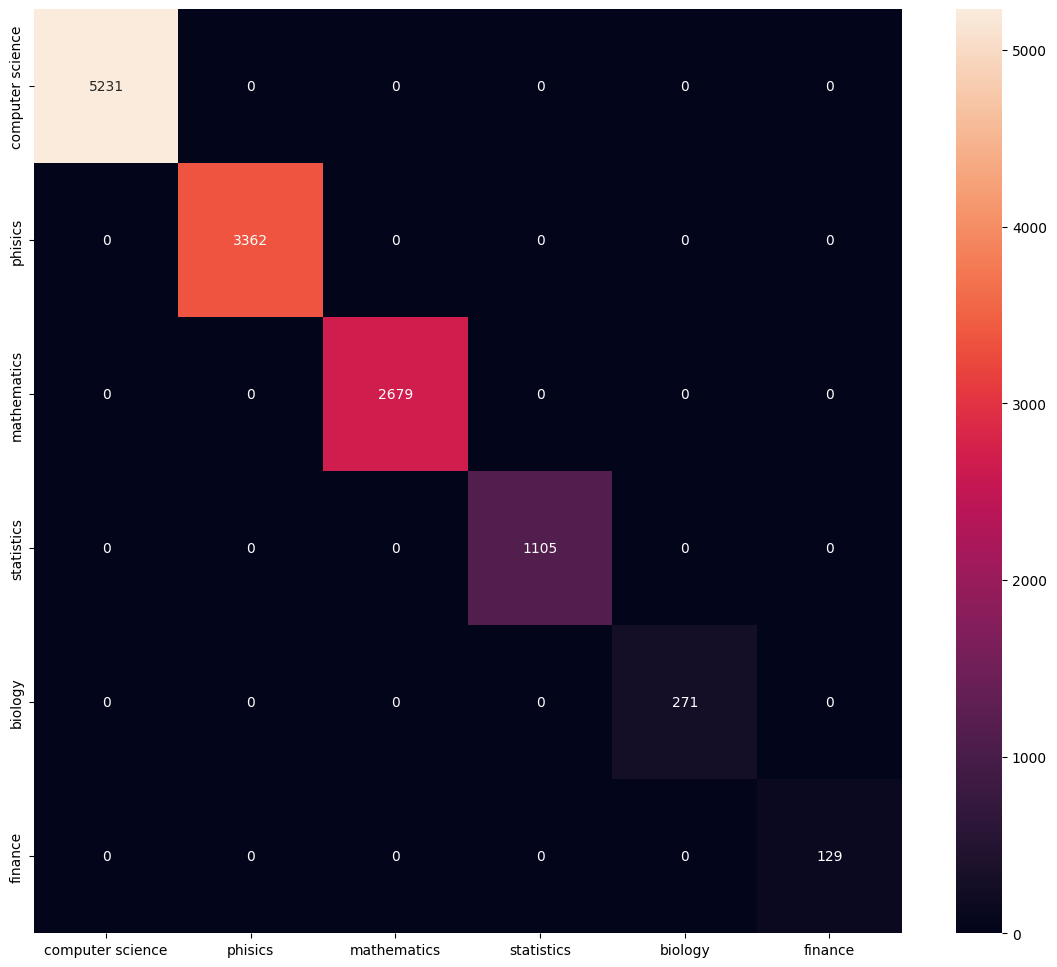

In [258]:
plt.figure(figsize=(14, 12))
sns.heatmap(train_cmatrix, annot=True, xticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'],
           yticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'], fmt='' )
plt.show()

On training data - if algoythm is predictin badly  - it is predictin the largest class - Computer science. Take a look for normalized matrix: 

In [260]:
train_cmatrix_norm = confusion_matrix(y_train, train_preds, normalize='true')
train_cmatrix_norm

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

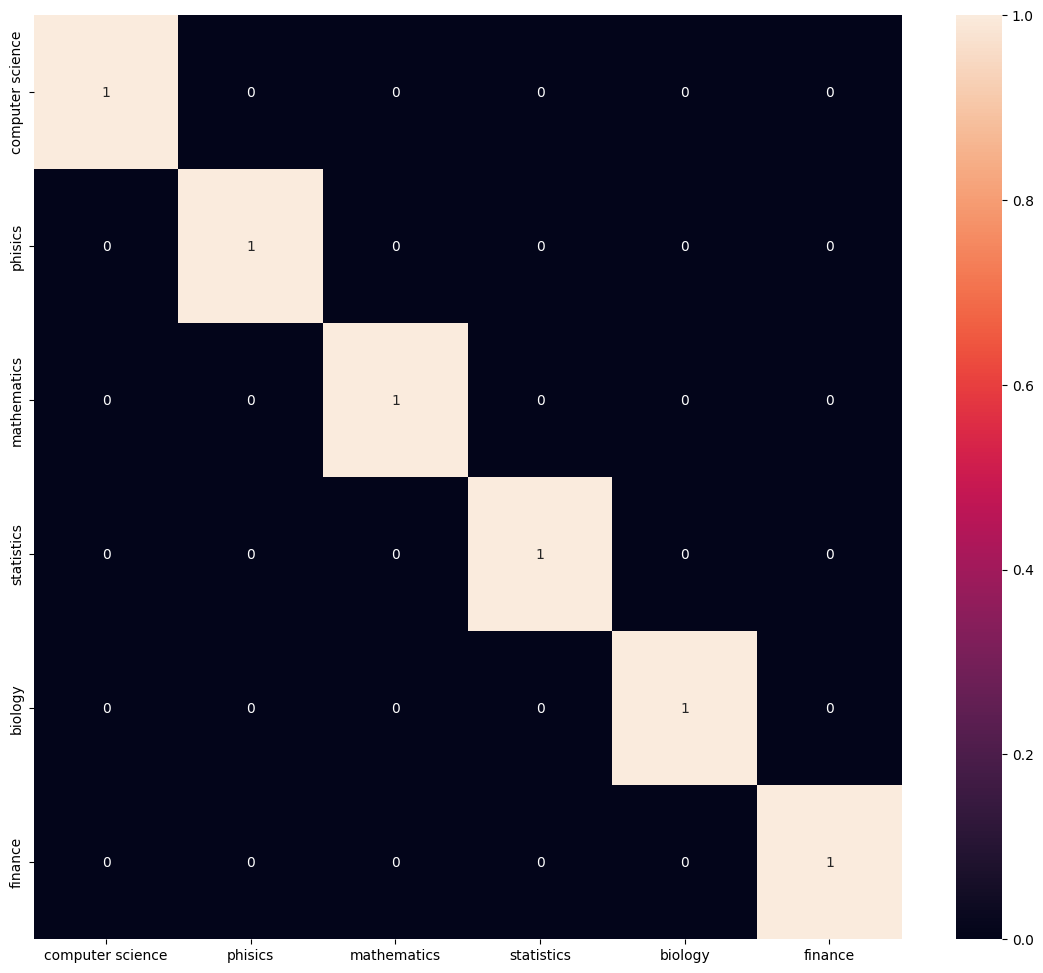

In [261]:
plt.figure(figsize=(14, 12))
sns.heatmap(train_cmatrix_norm, annot=True, xticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'],
           yticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'], fmt='.2g')
plt.show()

Let' make the same on test data:

In [263]:
test_cmatrix = confusion_matrix(y_test, preds)
test_cmatrix

array([[1156,   22,   62,   60,    5,    3],
       [  46,  743,   37,    4,   11,    0],
       [  62,   18,  561,   25,    0,    4],
       [ 166,    7,   21,   74,    5,    3],
       [  21,   13,    2,    0,   32,    0],
       [  11,    1,    0,    1,    0,   19]], dtype=int64)

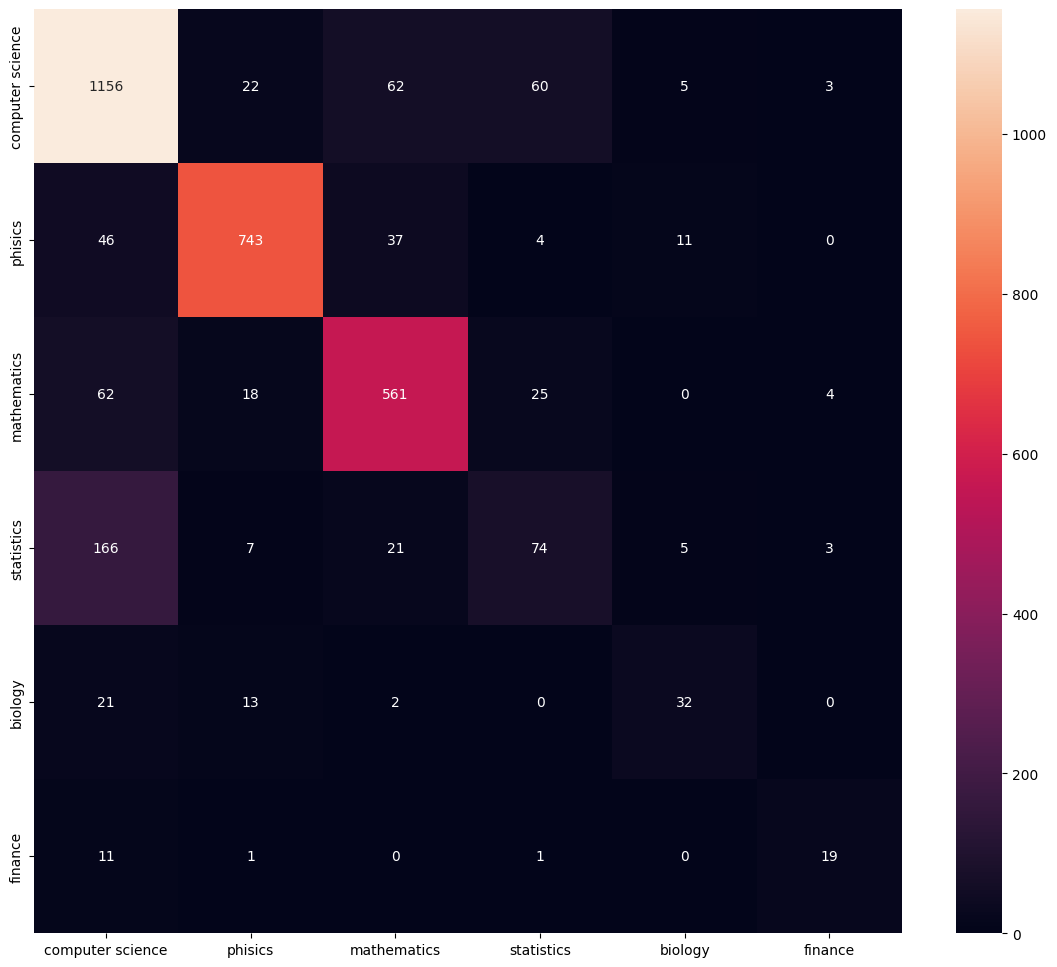

In [264]:
plt.figure(figsize=(14, 12))
sns.heatmap(test_cmatrix, annot=True, xticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'],
           yticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'], fmt='')
plt.show()

As we can se problem is the same. Suprising is fact, that for Statistics - more data is predictin Statistics as a Computer science, than it is predicting well. Look at normalized matrix:

In [266]:
test_cmatrix_norm = confusion_matrix(y_test, preds, normalize='true')
test_cmatrix_norm

array([[0.88379205, 0.01681957, 0.04740061, 0.04587156, 0.00382263,
        0.00229358],
       [0.05469679, 0.88347206, 0.04399524, 0.00475624, 0.01307967,
        0.        ],
       [0.09253731, 0.02686567, 0.83731343, 0.03731343, 0.        ,
        0.00597015],
       [0.60144928, 0.02536232, 0.07608696, 0.26811594, 0.01811594,
        0.01086957],
       [0.30882353, 0.19117647, 0.02941176, 0.        , 0.47058824,
        0.        ],
       [0.34375   , 0.03125   , 0.        , 0.03125   , 0.        ,
        0.59375   ]])

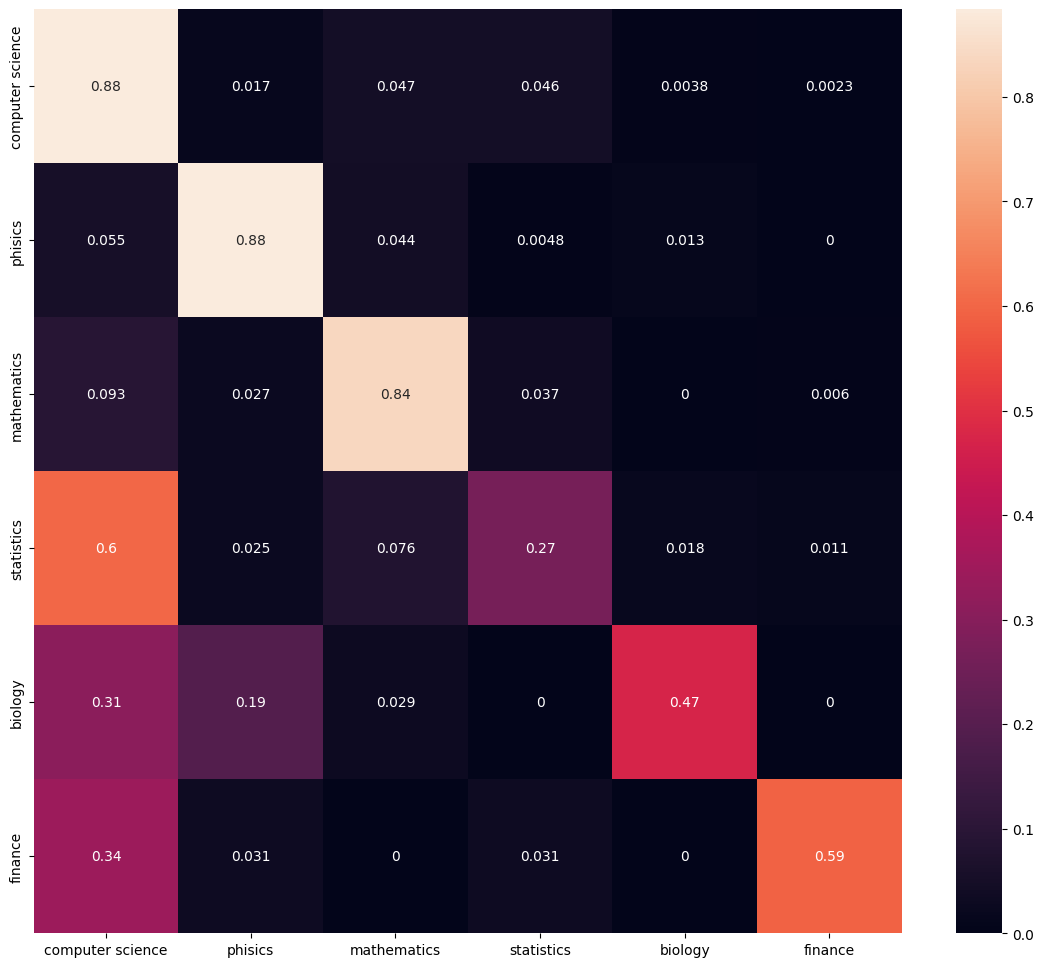

In [267]:
plt.figure(figsize=(14, 12))
sns.heatmap(test_cmatrix_norm, annot=True, xticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'],
           yticklabels=['computer science', 'phisics', 'mathematics', 'statistics', 'biology', 'finance'])
plt.show()

One of the method which is possible to use to prevent overfitting is to test it on cross validation. Let's do it:

In [269]:
X_stem = pd.concat([X_train_stem, X_test_stem])
y_all = pd.concat([y_train, y_test])

In [270]:
kfold = StratifiedKFold(5, shuffle=True, random_state=123)

In [271]:
pipeline = Pipeline([('tfidf', tfidf_2), ('vot', tfidf_vot_soft_1)])
cross_val_acc = cross_val_score(pipeline, X_stem, y_all, cv=kfold)

In [272]:
cross_val_acc

array([0.79467919, 0.82097027, 0.80400751, 0.80745147, 0.81433939])

In [273]:
np.mean(cross_val_acc)

0.8082895648433144

As we can see mean accuracy is very similar which we achieved on training data. Let's take a look for F1 scores:

In [275]:
cross_val_f1macro = cross_val_score(pipeline, X_stem, y_all, cv=kfold, scoring='f1_macro')

In [276]:
cross_val_f1macro

array([0.63406089, 0.61556155, 0.6094172 , 0.6099487 , 0.65325687])

In [277]:
np.mean(cross_val_f1macro)

0.624449042759557

Macro F1 is even lower than on test data.

In [279]:
cross_val_f1weighted = cross_val_score(pipeline, X_stem, y_all, cv=kfold, scoring='f1_weighted')

In [280]:
cross_val_f1weighted

array([0.78021544, 0.80370333, 0.7852045 , 0.78840842, 0.79799117])

In [281]:
np.mean(cross_val_f1weighted)

0.7911045722019935

But when we are using weights results are much better - it's because major classes are predicted well.

<a id="38"></a> 
## 12. Conclusion

As we can see major problem with predicting data in this dataset is fact, that minor classes are not predicted well by most of tested algorythms. Achieved accuracy is around 0.8 no mater are we using Word2Vec technique or Tfidf. Adventage on usage wof W2V is time of training, but Tfidf is givving beter results - but difference is not very large. 

My goal in this project was to achieve the best accuracy but there are also few techniques which are able to improve metrics:

- using pretrained LLM models like BERT
- Grid Search with other scoring method 
- Feature Engeenering by usage of regex techniques

At least achieved accuracy of 0.81 is quite good result. 

See you in next projects :)